# 安装库

In [ ]:
# 安装必要的库
%pip install requests
%pip install openai
%pip install langgraph langchain-openai

# 示例

In [11]:
import os
from openai import OpenAI

# 设置您的 API 密钥
YOUR_API_KEY = "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"
os.environ["PPLX_API_KEY"] = YOUR_API_KEY

# 初始化 API 客户端
client = OpenAI(api_key=YOUR_API_KEY, base_url="https://api.perplexity.ai")

# 定义聊天机器人函数
def chatbot(messages):
    response = client.chat.completions.create(
        model="llama-3.1-sonar-large-128k-online",
        messages=messages,
    )
    return response.choices[0].message.content

# 定义天气查询工具函数
def get_weather():
    return "今天的天气是晴天，温度25℃"

# 运行状态图并传递用户输入
user_input = "合肥今天天气怎么样？"
messages = [
    {
        "role": "system",
        "content": (
            "You are an artificial intelligence assistant and you need to "
            "engage in a helpful, detailed, polite conversation with a user."
        ),
    },
    {
        "role": "user",
        "content": user_input,
    },
]

# 获取聊天机器人响应
chat_response = chatbot(messages)

# 输出结果消息内容
print(chat_response)

# 如果需要使用天气查询工具，可以直接调用
weather_response = get_weather()
print(weather_response)

根据最新的天气预报，以下是关于合肥今天（11月28日）天气的信息：

## 气温
今天的气温范围为1°C到11°C[4][5].

## 天气状况
天气预报显示今天将是晴天，可能没有明显的降水[4][5].

## 风力
风向主要是西风或西北风，风力在3-5级之间[4][5].

## 其他建议
- 由于气温较低，建议着厚外套加毛衣等服装。
- 风力较大，洗车后可能会蒙上灰尘。
- 辐射较弱，建议涂擦SPF12-15、PA+防晒护肤品。
- 在户外运动时请注意增减衣物[5].
今天的天气是晴天，温度25℃


# 简单动态工作流

In [13]:
import json
import os
import re
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from typing import TypedDict, List, Annotated
import operator

# 设置您的 API 密钥
YOUR_API_KEY = "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"
os.environ["PPLX_API_KEY"] = YOUR_API_KEY

# 初始化 API 客户端
client = OpenAI(api_key=YOUR_API_KEY, base_url="https://api.perplexity.ai")

# 定义状态结构
class Task(TypedDict):
    id: str
    description: str
    depends_on: List[str]

class PlanState(TypedDict):
    tasks: Annotated[List[str], operator.add]  # 使用 operator.add 作为合并函数

# 1. 使用 LLM 生成结构化计划
def generate_plan(user_input):
    prompt = f"""
    请根据以下用户输入生成一个结构化计划，格式为纯 JSON，不要添加任何其他文本：
    用户输入: "{user_input}"
    输出格式:
    {{
        "tasks": [
            {{"id": "task1", "description": "任务描述1", "depends_on": []}},
            {{"id": "task2", "description": "任务描述2", "depends_on": ["task1"]}}
        ]
    }}
    """
    
    messages = [
        {
            "role": "system",
            "content": (
                "You are an artificial intelligence assistant and you need to "
                "generate a structured plan based on user input."
            ),
        },
        {
            "role": "user",
            "content": prompt,
        },
    ]
    
    response = client.chat.completions.create(
        model="llama-3.1-sonar-large-128k-online",
        messages=messages,
    )
    
    json_content = response.choices[0].message.content
    json_match = re.search(r'\{.*\}', json_content, re.DOTALL)

    if json_match:
        json_str = json_match.group(0)
        return json.loads(json_str)
    
    return None

# 示例用户输入
user_input = "准备一次旅行，包括订机票和酒店"
plan = generate_plan(user_input)
print("生成的计划:", plan)

# 2. 将计划转换为图结构
def build_graph(plan):
    graph_builder = StateGraph(state_schema=PlanState)

    for task in plan["tasks"]:
        task_id = task["id"]
        description = task["description"]
        
        def task_node(state: PlanState, task_description=description):
            print(f"执行: {task_description}")
            current_tasks = state.get("tasks", [])
            return {"tasks": current_tasks + [task_description]}  # 返回合并后的任务列表
        
        graph_builder.add_node(task_id, lambda state, desc=description: task_node(state, desc)) 

    for task in plan["tasks"]:
        task_id = task["id"]
        dependencies = task["depends_on"]
        
        if not dependencies:
            graph_builder.add_edge(START, task_id)
        
        for dep in dependencies:
            graph_builder.add_edge(dep, task_id)

    for task in plan["tasks"]:
        graph_builder.add_edge(task["id"], END)
    
    return graph_builder.compile()

# 构建图结构并执行
if plan:
    graph = build_graph(plan)

    # 调试输出图结构
    print("图结构:")
    for node in graph.nodes:
        print(f"Node ID: {node}")

    # 执行图并捕获异常
    try:
        initial_input = {"tasks": []}  # 初始状态可以根据需要调整
        response = graph.invoke(initial_input)
        print("所有任务已完成")
    except Exception as e:
        print(f"执行图时发生错误: {e}")

生成的计划: {'tasks': [{'id': 'task1', 'description': '研究和选择目的地', 'depends_on': []}, {'id': 'task2', 'description': '收集目的地的旅游信息（景点、酒店、交通等）', 'depends_on': ['task1']}, {'id': 'task3', 'description': '比较和选择机票', 'depends_on': ['task2']}, {'id': 'task4', 'description': '预订机票', 'depends_on': ['task3']}, {'id': 'task5', 'description': '比较和选择酒店', 'depends_on': ['task2']}, {'id': 'task6', 'description': '预订酒店', 'depends_on': ['task5']}, {'id': 'task7', 'description': '规划详细行程（包括交通、景点、餐厅等）', 'depends_on': ['task4', 'task6']}, {'id': 'task8', 'description': '确认和打印所有预订信息', 'depends_on': ['task7']}]}
图结构:
Node ID: __start__
Node ID: task1
Node ID: task2
Node ID: task3
Node ID: task4
Node ID: task5
Node ID: task6
Node ID: task7
Node ID: task8
执行: 研究和选择目的地
执行: 收集目的地的旅游信息（景点、酒店、交通等）
执行: 比较和选择机票
执行: 比较和选择酒店
执行: 预订机票
执行: 预订酒店
执行: 规划详细行程（包括交通、景点、餐厅等）
执行: 确认和打印所有预订信息
所有任务已完成


# 可视化

In [ ]:
%pip install networkx matplotlib

生成的计划: {'tasks': [{'id': 'task1', 'description': '确定旅行目的地和日期', 'depends_on': []}, {'id': 'task2', 'description': '搜索和比较机票价格', 'depends_on': ['task1']}, {'id': 'task3', 'description': '预订机票', 'depends_on': ['task2']}, {'id': 'task4', 'description': '搜索和比较酒店价格', 'depends_on': ['task1']}, {'id': 'task5', 'description': '预订酒店', 'depends_on': ['task4']}, {'id': 'task6', 'description': '规划旅行行程，包括景点和活动', 'depends_on': ['task3', 'task5']}, {'id': 'task7', 'description': '确认和保存旅行计划', 'depends_on': ['task6']}]}
图结构:
Node ID: task1
Node ID: task2
Node ID: task3
Node ID: task4
Node ID: task5
Node ID: task6
Node ID: task7


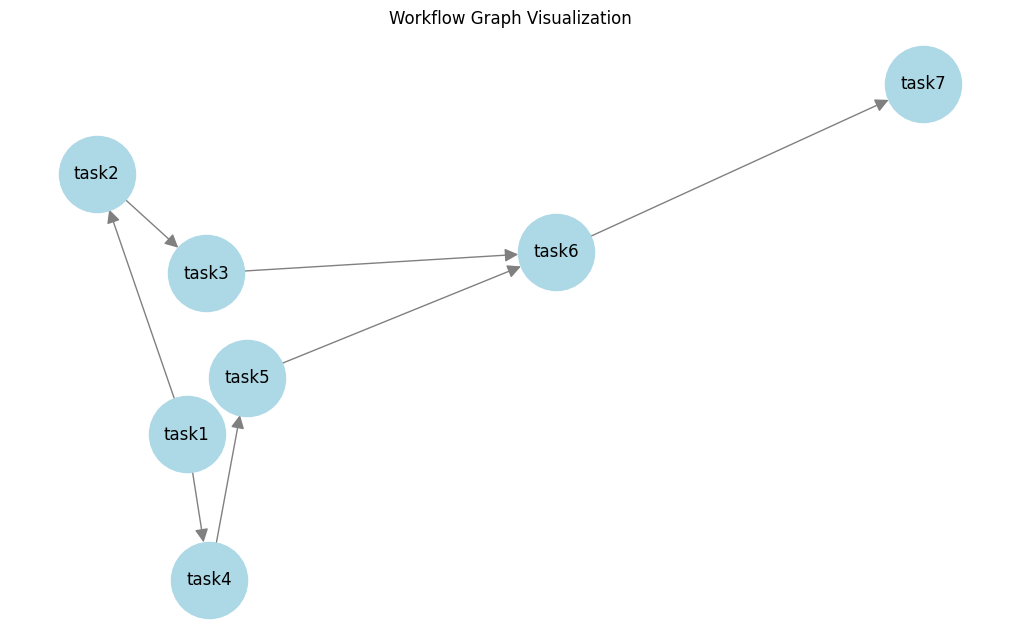

In [ ]:
import json
import os
import re
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from typing import TypedDict, List, Annotated
import operator
import networkx as nx
import matplotlib.pyplot as plt

# 设置您的 API 密钥
YOUR_API_KEY = "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"
os.environ["PPLX_API_KEY"] = YOUR_API_KEY

# 初始化 API 客户端
client = OpenAI(api_key=YOUR_API_KEY, base_url="https://api.perplexity.ai")

# 定义状态结构
class Task(TypedDict):
    id: str
    description: str
    depends_on: List[str]

class PlanState(TypedDict):
    tasks: Annotated[List[str], operator.add]  # 使用 operator.add 作为合并函数

# 1. 使用 LLM 生成结构化计划
def generate_plan(user_input):
    prompt = f"""
    请根据以下用户输入生成一个结构化计划，格式为纯 JSON，不要添加任何其他文本：
    用户输入: "{user_input}"
    输出格式:
    {{
        "tasks": [
            {{"id": "task1", "description": "任务描述1", "depends_on": []}},
            {{"id": "task2", "description": "任务描述2", "depends_on": ["task1"]}}
        ]
    }}
    """
    
    messages = [
        {
            "role": "system",
            "content": (
                "You are an artificial intelligence assistant and you need to "
                "generate a structured plan based on user input."
            ),
        },
        {
            "role": "user",
            "content": prompt,
        },
    ]
    
    response = client.chat.completions.create(
        model="llama-3.1-sonar-large-128k-online",
        messages=messages,
    )
    
    json_content = response.choices[0].message.content
    json_match = re.search(r'\{.*\}', json_content, re.DOTALL)

    if json_match:
        json_str = json_match.group(0)
        return json.loads(json_str)
    
    return None

# 示例用户输入
user_input = "准备一次旅行，包括订机票和酒店"
plan = generate_plan(user_input)
print("生成的计划:", plan)

# 2. 将计划转换为图结构并提取节点和边信息
def build_graph(plan):
    graph_builder = StateGraph(state_schema=PlanState)

    nodes = []
    edges = []

    for task in plan["tasks"]:
        task_id = task["id"]
        description = task["description"]
        
        def task_node(state: PlanState, task_description=description):
            print(f"执行: {task_description}")
            current_tasks = state.get("tasks", [])
            return {"tasks": current_tasks + [task_description]}
        
        graph_builder.add_node(task_id, lambda state, desc=description: task_node(state, desc))
        
        # 添加节点到列表（用于可视化）
        nodes.append(task_id)

    for task in plan["tasks"]:
        task_id = task["id"]
        dependencies = task["depends_on"]
        
        if not dependencies:
            graph_builder.add_edge(START, task_id)  # 无依赖任务从 START 开始
        
        for dep in dependencies:
            graph_builder.add_edge(dep, task_id)  # 添加依赖边
            
            # 添加边到列表（用于可视化）
            edges.append((dep, task_id))

    for task in plan["tasks"]:
        graph_builder.add_edge(task["id"], END)  # 所有任务完成后连接到 END
    
    return graph_builder.compile(), nodes, edges

# 构建图结构并提取节点和边信息
if plan:
    graph, nodes, edges = build_graph(plan)

    # 调试输出图结构
    print("图结构:")
    for node in nodes:
        print(f"Node ID: {node}")

# 3. 可视化工作流图结构
def visualize_graph(nodes, edges):
    G = nx.DiGraph()  # 创建有向图

    # 添加节点和边
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)

    # 绘制图形
    plt.figure(figsize=(10, 6))
    pos = nx.spring_layout(G)  # 自动布局算法，生成节点位置
    nx.draw(
        G,
        pos,
        with_labels=True,
        node_color='lightblue',
        arrowsize=20,
        node_size=3000,
        edge_color='gray'
    )
    
    plt.title('Workflow Graph Visualization')
    plt.show()

# 调用可视化函数
if plan:
    visualize_graph(nodes, edges)

# 复杂动态工作流

## 端侧

In [5]:
import json
import os
import re
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from typing import TypedDict, List, Annotated
import operator
from openai import OpenAI

# 设置您的 API 密钥
YOUR_API_KEY = "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"
os.environ["PPLX_API_KEY"] = YOUR_API_KEY

class Task(TypedDict):
    id: str
    description: str
    depends_on: List[str]

class PlanState(TypedDict):
    tasks: Annotated[List[str], operator.add]  # 使用 operator.add 作为合并函数

class EndPlanGraph:
    def __init__(self):
        self.client = OpenAI(api_key=YOUR_API_KEY, base_url="https://api.perplexity.ai")
        self.plan = None
        self.graph = None

    def generate_plan(self, user_input: str):
        prompt = f"""
        请根据以下用户输入生成一个结构化计划，格式为纯 JSON，不要添加任何其他文本：
        用户输入: "{user_input}"
        输出格式:
        {{
            "tasks": [
                {{"id": "task1", "description": "任务描述1", "depends_on": []}},
                {{"id": "task2", "description": "任务描述2", "depends_on": ["task1"]}}
            ]
        }}
        """
        
        messages = [
            {
                "role": "system",
                "content": (
                    "You are an artificial intelligence assistant and you need to "
                    "generate a structured plan based on user input."
                ),
            },
            {
                "role": "user",
                "content": prompt,
            },
        ]
        
        response = self.client.chat.completions.create(
            model="llama-3.1-sonar-large-128k-online",
            messages=messages,
        )
        
        json_content = response.choices[0].message.content
        json_match = re.search(r'\{.*\}', json_content, re.DOTALL)

        if json_match:
            json_str = json_match.group(0)
            self.plan = json.loads(json_str)
            print("生成的子任务的计划:", self.plan)
    
    def build_graph(self):
        if not self.plan:
            raise ValueError("没有可用的计划，请先生成计划。")
        
        graph_builder = StateGraph(state_schema=PlanState)

        for task in self.plan["tasks"]:
            task_id = task["id"]
            description = task["description"]
            
            def task_node(state: PlanState, task_description=description):
                print(f"执行: {task_description}")
                # 此处如果允许可以设置成异步调用（考虑依赖关系）
                current_tasks = state.get("tasks", [])
                return {"tasks": current_tasks + [task_description]}
            
            graph_builder.add_node(task_id, lambda state, desc=description: task_node(state, desc))

        for task in self.plan["tasks"]:
            task_id = task["id"]
            dependencies = task["depends_on"]
            
            if not dependencies:
                graph_builder.add_edge(START, task_id)
            
            for dep in dependencies:
                graph_builder.add_edge(dep, task_id)

        for task in self.plan["tasks"]:
            graph_builder.add_edge(task["id"], END)
        
        self.graph = graph_builder.compile()
    
    def execute_graph(self):
        if not self.graph:
            raise ValueError("没有可用的图，请先构建图。")
        
        try:
            initial_input = {"tasks": []}
            response = self.graph.invoke(initial_input)
            print("该子任务已完成")
        except Exception as e:
            print(f"执行图时发生错误: {e}")

    def run(self, user_input: str):
        self.generate_plan(user_input)
        self.build_graph()
        self.execute_graph()

# 使用示例
if __name__ == "__main__":
    travel_plan_graph = EndPlanGraph()
    travel_plan_graph.run("准备一次旅行，包括订机票和酒店")

生成的子任务的计划: {'tasks': [{'id': 'task1', 'description': '搜索和比较机票价格', 'depends_on': []}, {'id': 'task2', 'description': '订购机票', 'depends_on': ['task1']}, {'id': 'task3', 'description': '搜索和比较酒店价格和评价', 'depends_on': []}, {'id': 'task4', 'description': '订购酒店', 'depends_on': ['task3']}, {'id': 'task5', 'description': '确认旅行计划并保存相关信息', 'depends_on': ['task2', 'task4']}]}
执行: 搜索和比较机票价格
执行: 搜索和比较酒店价格和评价
执行: 订购机票
执行: 订购酒店
执行: 确认旅行计划并保存相关信息
该子任务已完成


## 云侧

In [ ]:
class CloudPlanGraph:
    def __init__(self):
        self.client = OpenAI(api_key=YOUR_API_KEY, base_url="https://api.perplexity.ai")
        self.plan = None
        self.graph = None

    def generate_plan(self, user_input: str):
        prompt = f"""
        请根据以下用户输入生成一个结构化计划，格式为纯 JSON，不要添加任何其他文本：
        用户输入: "{user_input}"
        输出格式:
        {{
            "tasks": [
                {{"id": "task1", "description": "任务描述1", "depends_on": []}},
                {{"id": "task2", "description": "任务描述2", "depends_on": ["task1"]}}
            ]
        }}
        """
        
        messages = [
            {
                "role": "system",
                "content": (
                    "You are an artificial intelligence assistant and you need to "
                    "generate a structured plan based on user input."
                ),
            },
            {
                "role": "user",
                "content": prompt,
            },
        ]
        
        response = self.client.chat.completions.create(
            model="llama-3.1-sonar-large-128k-online",
            messages=messages,
        )
        
        json_content = response.choices[0].message.content
        json_match = re.search(r'\{.*\}', json_content, re.DOTALL)

        if json_match:
            json_str = json_match.group(0)
            self.plan = json.loads(json_str)
            print("云侧生成的计划:", self.plan)
    
    def build_graph(self):
        if not self.plan:
            raise ValueError("没有可用的计划，请先生成计划。")
        
        graph_builder = StateGraph(state_schema=PlanState)

        for task in self.plan["tasks"]:
            task_id = task["id"]
            description = task["description"]
            
            def task_node(state: PlanState, task_description=description):
                print(f"调用Agents来完成子任务: {task_description}")
                # 此处如果允许可以设置成异步调用（考虑依赖关系）
                # 调用EndPlanGraph中的run方法
                end_plan_graph = EndPlanGraph()
                end_plan_graph.run(task_description)

                current_tasks = state.get("tasks", [])
                return {"tasks": current_tasks + [task_description]}
            
            graph_builder.add_node(task_id, lambda state, desc=description: task_node(state, desc))

        for task in self.plan["tasks"]:
            task_id = task["id"]
            dependencies = task["depends_on"]
            
            if not dependencies:
                graph_builder.add_edge(START, task_id)
            
            for dep in dependencies:
                graph_builder.add_edge(dep, task_id)

        for task in self.plan["tasks"]:
            graph_builder.add_edge(task["id"], END)
        
        self.graph = graph_builder.compile()
    
    def execute_graph(self):
        if not self.graph:
            raise ValueError("没有可用的图，请先构建图。")
        
        try:
            initial_input = {"tasks": []}
            response = self.graph.invoke(initial_input)
            print("所有任务已完成")
        except Exception as e:
            print(f"执行图时发生错误: {e}")

    def run(self, user_input: str):
        self.generate_plan(user_input)
        self.build_graph()
        self.execute_graph()

# 使用示例
if __name__ == "__main__":
    travel_plan_graph = CloudPlanGraph()
    travel_plan_graph.run("准备一次旅行，包括订机票和酒店")

云侧生成的计划: {'tasks': [{'id': 'task1', 'description': '通过视觉检测代理识别桌子上的红色球', 'depends_on': []}, {'id': 'task2', 'description': '通过数据处理代理确认红色球的位置和状态', 'depends_on': ['task1']}, {'id': 'task3', 'description': '发送指令给机械臂控制代理，执行抓取红色球的操作', 'depends_on': ['task2']}, {'id': 'task4', 'description': '通过机械臂控制代理移动红色球到架子上', 'depends_on': ['task3']}, {'id': 'task5', 'description': '通过视觉检测代理确认红色球已成功放置在架子上', 'depends_on': ['task4']}]}
调用Agents来完成子任务: 通过视觉检测代理识别桌子上的红色球
调用Agents来完成子任务: 通过数据处理代理确认红色球的位置和状态
调用Agents来完成子任务: 发送指令给机械臂控制代理，执行抓取红色球的操作
调用Agents来完成子任务: 通过机械臂控制代理移动红色球到架子上
调用Agents来完成子任务: 通过视觉检测代理确认红色球已成功放置在架子上
所有任务已完成


## 场景化（function call、parameter）

### 消息传递

In [7]:
from langgraph.graph import StateGraph
from typing_extensions import TypedDict

# 定义状态结构
class ChatState(TypedDict):
    messages: list

# 初始化图
graph = StateGraph(ChatState)

# 定义输入节点
def input_node(state: ChatState):
    user_input = "Hello, how are you?"
    state["messages"].append(user_input)
    return state

# 定义响应节点
def response_node(state: ChatState):
    user_message = state["messages"][-1]
    response_message = f"AI responds to: {user_message}"
    state["messages"].append(response_message)
    return state

# 添加节点到图中
graph.add_node("input", input_node)
graph.add_node("response", response_node)

# 定义边以连接节点
graph.add_edge("input", "response")

# 设置入口点
graph.set_entry_point("input")

# 编译图并获取可运行对象
runnable = graph.compile()

# 构建输入数据
initial_input = {"messages": []}  # 初始状态，消息列表为空

# 使用invoke方法来执行图形，并传入初始输入
final_state = runnable.invoke(initial_input)

# 输出最终状态
print(final_state)

{'messages': ['Hello, how are you?', 'AI responds to: Hello, how are you?']}


### 代理基类

In [401]:
import json
import os
import re
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from typing import TypedDict, List, Callable, Any
from openai import OpenAI

# 设置您的 API 密钥
YOUR_API_KEY = "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"
os.environ["PPLX_API_KEY"] = YOUR_API_KEY

class BaseGraph:
    def __init__(self, state_schema: TypedDict):
        self.client = OpenAI(api_key=YOUR_API_KEY, base_url="https://api.perplexity.ai")
        self.plan = None
        self.graph = None
        self.state_schema = state_schema

    def generate_plan(self, user_input: str, prompt: str):
        messages = [
            {
                "role": "system",
                "content": (
                    "You are an artificial intelligence assistant and you need to "
                    "generate a structured plan based on user input."
                ),
            },
            {
                "role": "user",
                "content": prompt.format(user_input=user_input),
            },
        ]
        
        response = self.client.chat.completions.create(
            model="llama-3.1-sonar-large-128k-online",
            messages=messages,
        )
        
        json_content = response.choices[0].message.content
        json_match = re.search(r'\{.*\}', json_content, re.DOTALL)

        if json_match:
            json_str = json_match.group(0)
            self.plan = json.loads(json_str)
            print("生成的子任务的计划:", self.plan)

    def build_graph(self, task_node_func: Callable[[Any], Any]):
        if not self.plan:
            raise ValueError("没有可用的计划，请先生成计划。")
        
        graph_builder = StateGraph(state_schema=self.state_schema)

        # 添加所有任务节点
        for task in self.plan["tasks"]:
            task_id = task["id"]
            graph_builder.add_node(task_id, lambda state, task=task: task_node_func(state, task))

        # 添加边
        for task in self.plan["tasks"]:
            dependencies = task["depends_on"]
            if not dependencies:
                graph_builder.add_edge(START, task["id"])  # 连接到起始节点
            
            for dep in dependencies:
                graph_builder.add_edge(dep, task["id"])

        # 在所有任务连接完成后，再将每个任务连接到 END 节点
        for task in self.plan["tasks"]:
            graph_builder.add_edge(task["id"], END)
        
        self.graph = graph_builder.compile()


    def execute_graph(self):
        if not self.graph:
            raise ValueError("没有可用的图，请先构建图。")
        
        try:
            initial_input = {"tasks": []}
            response = self.graph.invoke(initial_input)
            print("该子任务已完成", response)
        except Exception as e:
            print(f"执行图时发生错误: {e}")

    def run(self, user_input: str, prompt: str, task_node_func: Callable[[Any], Any]):
        self.generate_plan(user_input, prompt)
        self.build_graph(task_node_func)
        self.execute_graph()

## 机械臂场景

### 视觉识别代理

In [227]:

class EyePlanState(TypedDict):
    tasks: List[str]
    image_data: str
    object_data: str
    material_data: str
    pose_data: str

class EyePlanGraph(BaseGraph):
    def __init__(self):
        super().__init__(state_schema=EyePlanState)

    def generate_prompt(self) -> str:
        return """
            ### API Description

            1. **Capture Current Image API**
            - **Name**: capture_image
            - **Parameters**: None

            2. **Detect and Recognize Objects API**
            - **Name**: detect_and_recognize_objects
            - **Parameters**:
                - `image`: The image data to be processed.
                - `threshold`: The confidence threshold for detection (e.g., 0.5).

            3. **Classify Material API**
            - **Name**: classify_material
            - **Parameters**:
                - `object_features`: The features of the object to classify its material.

            4. **Get Object Pose API**
            - **Name**: get_object_pose
            - **Parameters**:
                - `object_id`: The identifier of the object whose pose is to be retrieved.

            Please generate a structured plan based on the following user input, formatted as pure JSON without adding any other text:
            
            User Input: "{user_input}"
            
            Output Format:
            {{
                "tasks": [
                    {{"id": "task1", "description": "Capture the current image from the camera", "api_name": "capture_image", "api_params": {{}} , "depends_on": []}},
                    {{"id": "task2", "description": "Detect and recognize objects in the captured image", "api_name": "detect_and_recognize_objects", "api_params": {{"image": "captured_image_data", "threshold": 0.5}}, "depends_on": ["task1"]}},
                    {{"id": "task3", "description": "Classify the material of recognized objects", "api_name": "classify_material", "api_params": {{"object_features": "recognized_object_features"}}, "depends_on": ["task2"]}},
                    {{"id": "task4", "description": "Get the pose of the recognized object", "api_name": "get_object_pose", "api_params": {{"object_id": "recognized_object_id"}}, "depends_on": ["task3"]}}
                ]
            }}
            
            Please ensure that each sub-task includes the name of the API to be called and the corresponding parameters for subsequent calls. If parameters related to the current task can be extracted from the context, use those extracted parameters instead of temporary placeholders.
        """

    def task_node(self, state: EyePlanState, task):
        description = task["description"]
        api_name = task["api_name"]
        api_params = task["api_params"]
        
        print(f"执行: {description}，调用API: {api_name}，参数: {api_params}")
        
        # 模拟API调用结果（根据API名称返回相应的数据）
        if api_name == "capture_image":
            return {
                "tasks": state.get("tasks", []),
                "image_data": "image1.jpg"
            }     
        elif api_name == "detect_and_recognize_objects":
            return {
                "tasks": state.get("tasks", []),
                "image_data": state.get("image_data", ""),
                "object_data": "a paper cup"
            }
        elif api_name == "classify_material":
            return {
                "tasks": state.get("tasks", []),
                "image_data": state.get("image_data", ""),
                "object_data": state.get("object_data", ""),
                "material_data": "paper"
            }
        elif api_name == "get_object_pose":
            return {
                "tasks": state.get("tasks", []),
                "image_data": state.get("image_data", ""),
                "object_data": state.get("object_data", ""),
                "material_data": state.get("material_data", ""),
                "pose_data": "the paper cup (x=10, y=20, z=0), the shelf (x=30, y=30, z=0)"
            }    
    
if __name__ == "__main__":
    travel_plan_graph = EyePlanGraph()
    travel_plan_graph.run("Help me move the paper cups from the table to the shelf.", travel_plan_graph.generate_prompt(), travel_plan_graph.task_node)

生成的子任务的计划: {'tasks': [{'id': 'task1', 'description': 'Capture the current image from the camera', 'api_name': 'capture_image', 'api_params': {}, 'depends_on': []}, {'id': 'task2', 'description': 'Detect and recognize objects in the captured image', 'api_name': 'detect_and_recognize_objects', 'api_params': {'image': 'captured_image_data', 'threshold': 0.5}, 'depends_on': ['task1']}, {'id': 'task3', 'description': 'Classify the material of recognized objects', 'api_name': 'classify_material', 'api_params': {'object_features': 'recognized_object_features'}, 'depends_on': ['task2']}, {'id': 'task4', 'description': 'Get the pose of the recognized object', 'api_name': 'get_object_pose', 'api_params': {'object_id': 'recognized_object_id'}, 'depends_on': ['task3']}]}
执行: Capture the current image from the camera，调用API: capture_image，参数: {}
执行: Detect and recognize objects in the captured image，调用API: detect_and_recognize_objects，参数: {'image': 'captured_image_data', 'threshold': 0.5}
执行: Classi

### 运动规划代理

In [228]:
class MovePlanState(TypedDict):
    tasks: List[str]
    path_data: str
    obstacle_data: str
    trajectory_data: str

class MovePlanGraph(BaseGraph):
    def __init__(self):
        super().__init__(state_schema=MovePlanState)

    def generate_prompt(self) -> str:
        return """
            ### API Description

            1. **Plan Path API**
            - **Name**: plan_path
            - **Parameters**:
                - `start_position`: The starting position coordinates of the robotic arm.
                - `target_position`: The coordinates of the target position.

            2. **Avoid Obstacles API**
            - **Name**: avoid_obstacles
            - **Parameters**:
                - `path`: The initially planned motion path.

            3. **Get Trajectory API**
            - **Name**: get_trajectory
            - **Parameters**: None

            4. **Execute Movement API**
            - **Name**: execute_movement
            - **Parameters**:
                - `trajectory`: The information of the planned motion trajectory.

            Please generate a structured plan based on the following user input, formatted as pure JSON without adding any other text:
            
            User Input: "{user_input}"
            
            Output Format:
            {{
                "tasks": [
                    {{"id": "task1", "description": "Plan the motion path from the starting position to the target position", "api_name": "plan_path", "api_params": {{"start_position": "starting_coordinates", "target_position": "target_coordinates"}}, "depends_on": []}},
                    {{"id": "task2", "description": "Consider obstacles in the path planning and return the obstacle-free path", "api_name": "avoid_obstacles", "api_params": {{"path": "initial_path"}}, "depends_on": ["task1"]}},
                    {{"id": "task3", "description": "Get the information of the planned motion trajectory", "api_name": "get_trajectory", "api_params": {{}}, "depends_on": ["task2"]}},
                    {{"id": "task4", "description": "Execute the specified motion trajectory", "api_name": "execute_movement", "api_params": {{"trajectory": "trajectory_info"}}, "depends_on": ["task3"]}}
                ]
            }}
            
            Please ensure that each sub-task includes the name of the API to be called and the corresponding parameters for subsequent calls. If parameters related to the current task can be extracted from the context, use those extracted parameters instead of temporary placeholders.
        """
            
    def task_node(self, state: MovePlanState, task):
        description = task["description"]
        api_name = task["api_name"]
        api_params = task["api_params"]
        
        print(f"执行: {description}，调用API: {api_name}，参数: {api_params}")
        # 模拟API调用结果
        if api_name == "plan_path":
            return {
                "tasks": state.get("tasks", []),
                "path_data": "(10, 20, 0) -> (30, 30, 0)."
            }
        elif api_name == "avoid_obstacles":
            return {
                "tasks": state.get("tasks", []),
                "path_data": state.get("path_data", ""),
                "obstacle_data": "A obstacles(20, 30, 10)."
            }
        elif api_name == "get_trajectory":
            return {
                "tasks": state.get("tasks", []),
                "path_data": state.get("path_data", ""),
                "obstacle_data": state.get("obstacle_data", ""),
                "trajectory_data": "(10, 20, 0) -> (30, 0, 0) -> (30, 30, 0)."
            }
        elif api_name == "execute_movement":
            return {
                "tasks": state.get("tasks", []),
                "path_data": state.get("path_data", ""),
                "obstacle_data": state.get("obstacle_data", ""),
                "trajectory_data": state.get("trajectory_data", "")
            }

# 使用示例
if __name__ == "__main__":
    travel_plan_graph = MovePlanGraph()
    travel_plan_graph.run("Help me move the paper cups from the table to the shelf.", travel_plan_graph.generate_prompt(), travel_plan_graph.task_node)

生成的子任务的计划: {'tasks': [{'id': 'task1', 'description': 'Plan the motion path from the starting position to the target position', 'api_name': 'plan_path', 'api_params': {'start_position': 'table_coordinates', 'target_position': 'shelf_coordinates'}, 'depends_on': []}, {'id': 'task2', 'description': 'Consider obstacles in the path planning and return the obstacle-free path', 'api_name': 'avoid_obstacles', 'api_params': {'path': 'initial_path'}, 'depends_on': ['task1']}, {'id': 'task3', 'description': 'Get the information of the planned motion trajectory', 'api_name': 'get_trajectory', 'api_params': {}, 'depends_on': ['task2']}, {'id': 'task4', 'description': 'Execute the specified motion trajectory', 'api_name': 'execute_movement', 'api_params': {'trajectory': 'trajectory_info'}, 'depends_on': ['task3']}]}
执行: Plan the motion path from the starting position to the target position，调用API: plan_path，参数: {'start_position': 'table_coordinates', 'target_position': 'shelf_coordinates'}
执行: Consid

### 抓取策略代理

In [229]:
class HandPlanState(TypedDict):
    tasks: List[str]
    gripper_data: str
    force_data: str
    action_data: str

class HandPlanGraph(BaseGraph):
    def __init__(self):
        super().__init__(state_schema=HandPlanState)

    def generate_prompt(self) -> str:
        return """
            ### API Description

            1. **Select Gripper API**
            - **Name**: select_gripper
            - **Parameters**:
                - `object_type`: The type of object to be grasped (e.g., fragile, heavy, irregular shape).

            2. **Calculate Grip Force API**
            - **Name**: calculate_grip_force
            - **Parameters**:
                - `object_weight`: The weight of the object to be grasped.
                - `gripper_type`: The type of gripper being used (e.g., claw, suction cup).

            3. **Execute Grasp API**
            - **Name**: execute_grasp
            - **Parameters**:
                - `gripper`: The type of gripper used (e.g., claw, suction cup).
                - `object_id`: The identifier of the object to be grasped.

            4. **Get Grasp Status API**
            - **Name**: get_grasp_status
            - **Parameters**: None

            Please generate a structured plan based on the following user input, formatted as pure JSON without adding any other text:
            
            User Input: "{user_input}"
            
            Output Format:
            {{
                "tasks": [
                    {{"id": "task1", "description": "Select an appropriate gripper for the object", "api_name": "select_gripper", "api_params": {{"object_type": "type_of_object"}}, "depends_on": []}},
                    {{"id": "task2", "description": "Calculate the required grip force for the object", "api_name": "calculate_grip_force", "api_params": {{"object_weight": "weight_of_object", "gripper_type": "selected_gripper"}}, "depends_on": ["task1"]}},
                    {{"id": "task3", "description": "Execute the grasp using the selected gripper", "api_name": "execute_grasp", "api_params": {{"gripper": "selected_gripper", "object_id": "object_identifier"}}, "depends_on": ["task2"]}},
                    {{"id": "task4", "description": "Get the current status of the grasping action", "api_name": "get_grasp_status", "api_params": {{}}, "depends_on": ["task3"]}}
                ]
            }}
            
            Please ensure that each sub-task includes the name of the API to be called and the corresponding parameters for subsequent calls. If parameters related to the current task can be extracted from the context, use those extracted parameters instead of temporary placeholders.
        """
            
    def task_node(self, state: HandPlanState, task):
        description = task["description"]
        api_name = task["api_name"]
        api_params = task["api_params"]
        
        print(f"执行: {description}，调用API: {api_name}，参数: {api_params}")
        # 模拟API调用结果
        if api_name == "select_gripper":
            return {
                "tasks": state.get("tasks", []),
                "gripper_data": "claw"
            }
        elif api_name == "calculate_grip_force":
            return {
                "tasks": state.get("tasks", []),
                "gripper_data": state.get("gripper_data", ""),
                "force_data": "10 N"
            }
        elif api_name == "execute_grasp":
            return {
                "tasks": state.get("tasks", []),
                "gripper_data": state.get("gripper_data", ""),
                "force_data": state.get("force_data", ""),
                "action_data": "Grasping action executed successfully"
            }
        elif api_name == "get_grasp_status":
            return {
                "tasks": state.get("tasks", []),
                "gripper_data": state.get("gripper_data", ""),
                "force_data": state.get("force_data", ""),
                "action_data": state.get("action_data", "")
            }
# 使用示例
if __name__ == "__main__":
    travel_plan_graph = HandPlanGraph()
    travel_plan_graph.run("Help me move the paper cups from the table to the shelf.", travel_plan_graph.generate_prompt(), travel_plan_graph.task_node)

生成的子任务的计划: {'tasks': [{'id': 'task1', 'description': 'Select an appropriate gripper for the object', 'api_name': 'select_gripper', 'api_params': {'object_type': 'fragile'}, 'depends_on': []}, {'id': 'task2', 'description': 'Calculate the required grip force for the object', 'api_name': 'calculate_grip_force', 'api_params': {'object_weight': 'weight_of_paper_cup', 'gripper_type': 'selected_gripper'}, 'depends_on': ['task1']}, {'id': 'task3', 'description': 'Execute the grasp using the selected gripper', 'api_name': 'execute_grasp', 'api_params': {'gripper': 'selected_gripper', 'object_id': 'paper_cup_identifier'}, 'depends_on': ['task2']}, {'id': 'task4', 'description': 'Get the current status of the grasping action', 'api_name': 'get_grasp_status', 'api_params': {}, 'depends_on': ['task3']}]}
执行: Select an appropriate gripper for the object，调用API: select_gripper，参数: {'object_type': 'fragile'}
执行: Calculate the required grip force for the object，调用API: calculate_grip_force，参数: {'object_

### 执行控制代理

In [230]:
class ExecutePlanState(TypedDict):
    tasks: List[str]
    move_data: str
    grip_data: str
    release_data: str
    status_data: str

class ExecutePlanGraph(BaseGraph):
    def __init__(self):
        super().__init__(state_schema=ExecutePlanState)

    def generate_prompt(self) -> str:
        return """
            ### API Description

            1. **Move Arm to Specified Position API**
            - **Name**: move_arm_to_position
            - **Parameters**:
                - `position`: The coordinates of the target position.

            2. **Grip Object API**
            - **Name**: grip_object
            - **Parameters**:
                - `gripper`: The type of gripper used (e.g., claw, suction cup).

            3. **Release Object API**
            - **Name**: release_object
            - **Parameters**:
                - `gripper`: The type of gripper used to release the object.

            4. **Get Arm Status API**
            - **Name**: get_status
            - **Parameters**: None

            Please generate a structured plan based on the following user input, formatted as pure JSON without adding any other text:
            
            User Input: "{user_input}"
            
            Output Format:
            {{
                "tasks": [
                    {{"id": "task1", "description": "Move the arm to the target position", "api_name": "move_arm_to_position", "api_params": {{"position": "coordinates"}}, "depends_on": []}},
                    {{"id": "task2", "description": "Use the claw to grip the object", "api_name": "grip_object", "api_params": {{"gripper": "claw"}}, "depends_on": ["task1"]}},
                    {{"id": "task3", "description": "Release the gripped object", "api_name": "release_object", "api_params": {{"gripper": "claw"}}, "depends_on": ["task2"]}},
                    {{"id": "task4", "description": "Get the current status of the arm", "api_name": "get_status", "api_params": {{}}, "depends_on": ["task3"]}}
                ]
            }}
            
            Please ensure that each sub-task includes the name of the API to be called and the corresponding parameters for subsequent calls. If parameters related to the current task can be extracted from the context, use those extracted parameters instead of temporary placeholders.
        """
            
    def task_node(self, state: ExecutePlanState, task):
        description = task["description"]
        api_name = task["api_name"]
        api_params = task["api_params"]

        print(f"执行: {description}，调用API: {api_name}，参数: {api_params}")         
        # 模拟API调用结果
        if api_name == "move_arm_to_position":
            return {
                "tasks": state.get("tasks", []),
                "move_data": "target position (10, 20, 0)."
            }
        elif api_name == "grip_object":
            return {
                "tasks": state.get("tasks", []),
                "move_data": state.get("move_data", ""),
                "grip_data": "Object gripped"
            }
        elif api_name == "release_object":
            return {
                "tasks": state.get("tasks", []),
                "move_data": state.get("move_data", ""),
                "grip_data": state.get("grip_data", ""),
                "release_data": "Object released"
            }
        elif api_name == "get_status":
            return {
                "tasks": state.get("tasks", []),
                "move_data": state.get("move_data", ""),
                "grip_data": state.get("grip_data", ""),
                "release_data": state.get("release_data", ""),
                "status_data": "Ready."
            }
# 使用示例
if __name__ == "__main__":
    travel_plan_graph = ExecutePlanGraph()
    travel_plan_graph.run("Help me move the paper cups from the table to the shelf.", travel_plan_graph.generate_prompt(), travel_plan_graph.task_node)

生成的子任务的计划: {'tasks': [{'id': 'task1', 'description': 'Move the arm to the target position', 'api_name': 'move_arm_to_position', 'api_params': {'position': 'coordinates of the shelf'}, 'depends_on': []}, {'id': 'task2', 'description': 'Use the claw to grip the object', 'api_name': 'grip_object', 'api_params': {'gripper': 'claw'}, 'depends_on': ['task1']}, {'id': 'task3', 'description': 'Release the gripped object', 'api_name': 'release_object', 'api_params': {'gripper': 'claw'}, 'depends_on': ['task2']}, {'id': 'task4', 'description': 'Get the current status of the arm', 'api_name': 'get_status', 'api_params': {}, 'depends_on': ['task3']}]}
执行: Move the arm to the target position，调用API: move_arm_to_position，参数: {'position': 'coordinates of the shelf'}
执行: Use the claw to grip the object，调用API: grip_object，参数: {'gripper': 'claw'}
执行: Release the gripped object，调用API: release_object，参数: {'gripper': 'claw'}
执行: Get the current status of the arm，调用API: get_status，参数: {}
该子任务已完成 {'tasks': []

### 反馈与调整代理

In [231]:
class JustPlanState(TypedDict):
    tasks: List[str]
    arm_status: str
    error_status: str
    path_status: str
    data_status: str

class JustPlanGraph(BaseGraph):
    def __init__(self):
        super().__init__(state_schema=JustPlanState)

    def generate_prompt(self) -> str:
        return """
            ### API Description

            1. **Monitor Execution Status API**
            - **Name**: monitor_execution
            - **Parameters**: None

            2. **Check for Errors API**
            - **Name**: check_for_errors
            - **Parameters**:
                - `task_id`: The ID of the task to check for errors.

            3. **Adjust Motion Path API**
            - **Name**: adjust_motion_path
            - **Parameters**:
                - `new_path`: The updated motion path to be followed.

            4. **Log Execution Data API**
            - **Name**: log_execution_data
            - **Parameters**:
                - `data`: The data to be logged for analysis.

            Please generate a structured plan based on the following user input, formatted as pure JSON without adding any other text:
            
            User Input: "{user_input}"
            
            Output Format:
            {{
                "tasks": [
                    {{"id": "task1", "description": "Monitor the execution status of the robotic arm", "api_name": "monitor_execution", "api_params": {{}}, "depends_on": []}},
                    {{"id": "task2", "description": "Check for errors in the previous task execution", "api_name": "check_for_errors", "api_params": {{"task_id": "task4"}}, "depends_on": ["task1"]}},
                    {{"id": "task3", "description": "Adjust the motion path if necessary", "api_name": "adjust_motion_path", "api_params": {{"new_path": "updated_path"}}, "depends_on": ["task2"]}},
                    {{"id": "task4", "description": "Log the execution data for future analysis", "api_name": "log_execution_data", "api_params": {{"data": "execution_data"}}, "depends_on": ["task3"]}}
                ]
            }}
            
            Please ensure that each sub-task includes the name of the API to be called and the corresponding parameters for subsequent calls. If parameters related to the current task can be extracted from the context, use those extracted parameters instead of temporary placeholders.
        """
    
    def task_node(self, state: JustPlanState, task):
        description = task["description"]
        api_name = task["api_name"]
        api_params = task["api_params"]

        print(f"执行: {description}，调用API: {api_name}，参数: {api_params}")     
        # 模拟API调用结果
        if api_name == "monitor_execution":
            return {
                "tasks": state.get("tasks", []),
                "arm_status": "Ready."
            }
        elif api_name == "check_for_errors":
            return {
                "tasks": state.get("tasks", []),
                "arm_status": state.get("arm_status", ""),
                "error_status": "No errors found."
            }
        elif api_name == "adjust_motion_path":
            return {
                "tasks": state.get("tasks", []),
                "arm_status": state.get("arm_status", ""),
                "error_status": state.get("error_status", ""),
                "path_status": "Path adjusted."
            }
        elif api_name == "log_execution_data":
            return {
                "tasks": state.get("tasks", []),
                "arm_status": state.get("arm_status", ""),
                "error_status": state.get("error_status", ""),
                "path_status": state.get("path_status", ""),
                "data_status": "Data logged."
            }

# 使用示例
if __name__ == "__main__":
    travel_plan_graph = JustPlanGraph()
    travel_plan_graph.run("Help me move the paper cups from the table to the shelf.", travel_plan_graph.generate_prompt(), travel_plan_graph.task_node)

生成的子任务的计划: {'tasks': [{'id': 'task1', 'description': 'Monitor the execution status of the robotic arm', 'api_name': 'monitor_execution', 'api_params': {}, 'depends_on': []}, {'id': 'task2', 'description': 'Check for errors in the previous task execution', 'api_name': 'check_for_errors', 'api_params': {'task_id': 'task4'}, 'depends_on': ['task1']}, {'id': 'task3', 'description': 'Adjust the motion path if necessary', 'api_name': 'adjust_motion_path', 'api_params': {'new_path': 'updated_path'}, 'depends_on': ['task2']}, {'id': 'task4', 'description': 'Log the execution data for future analysis', 'api_name': 'log_execution_data', 'api_params': {'data': 'execution_data'}, 'depends_on': ['task3']}]}
执行: Monitor the execution status of the robotic arm，调用API: monitor_execution，参数: {}
执行: Check for errors in the previous task execution，调用API: check_for_errors，参数: {'task_id': 'task4'}
执行: Adjust the motion path if necessary，调用API: adjust_motion_path，参数: {'new_path': 'updated_path'}
执行: Log the 

### 机械臂云侧

In [232]:
class PlanState(TypedDict):
    tasks: Annotated[List[str], operator.add]  # 使用 operator.add 作为合并函数
    vision_recognition_agent_message: str
    motion_planning_agent_message: str
    grasping_strategy_agent_message: str
    execution_control_agent_message: str
    feedback_adjustment_agent_message: str

class CloudPlanGraph:
    def __init__(self):
        self.client = OpenAI(api_key=YOUR_API_KEY, base_url="https://api.perplexity.ai")
        self.plan = None
        self.graph = None

    def generate_plan(self, user_input: str):
        prompt = f"""
            ### Agent Capability Description

            1. **Vision Recognition Agent**
            - **Role**: Responsible for identifying and classifying objects, determining their position, shape, and material.
            - **Capabilities**:
                - Capture images from the current camera.
                - Detect and recognize objects in the image, returning object categories and location information.
                - Classify materials based on object characteristics (e.g., metal, plastic, glass).
                - Obtain the pose information of objects in three-dimensional space.
            - **Task Scope**:
                - Confirm the existence of the target object before executing tasks and return relevant information.

            2. **Motion Planning Agent**
            - **Role**: Generate the motion path for the robotic arm based on vision recognition results.
            - **Capabilities**:
                - Plan a motion path from the starting position to the target position.
                - Consider obstacles during path planning, returning a path that avoids them.
                - Obtain information about the planned motion trajectory.
                - Execute the specified motion trajectory.
            - **Task Scope**:
                - Receive object position information from the vision recognition agent to generate a motion plan.

            3. **Grasping Strategy Agent**
            - **Role**: Choose an appropriate grasping strategy based on object type and grasping method.
            - **Capabilities**:
                - Select an appropriate gripper based on object type (e.g., mechanical claw, vacuum suction).
                - Calculate the required grasping force to safely grasp objects.
                - Execute grasping actions to pick up specified objects with the robotic arm.
            - **Task Scope**:
                - Select an appropriate grasping strategy based on information provided by the vision recognition agent.

            4. **Execution Control Agent**
            - **Role**: Control the actual execution process of the robotic arm, including grasping and moving.
            - **Capabilities**:
                - Move the robotic arm to a specified position.
                - Control the gripper to execute grasping actions.
                - Control the gripper to release objects.
                - Obtain the current status of the robotic arm (e.g., whether it is in motion, whether it successfully grasped an object).
            - **Task Scope**:
                - Receive instructions from both the motion planning agent and the grasping strategy agent to execute specific actions.

            5. **Feedback and Adjustment Agent**
            - **Role**: Monitor real-time feedback during execution and make adjustments as needed.
            - **Capabilities**:
                - Monitor the execution status of the robotic arm in real-time, checking for errors or deviations.
                - Adjust motion paths based on feedback to optimize execution effectiveness.
                - Record data during execution for subsequent analysis and optimization.
            - **Task Scope**:
                - Monitor status during execution and make adjustments as necessary.

            Please generate a structured plan based on the following user input, formatted as pure JSON without adding any other text:
            
            User Input: "{user_input}"
            
            Output Format:
            {{
                "tasks": [
                    {{"id": "task1", "description": "Capture images of the target object and perform recognition", "assigned_agent": "Vision Recognition Agent", "depends_on": []}},
                    {{"id": "task2", "description": "Generate a motion path to move to the target position", "assigned_agent": "Motion Planning Agent", "depends_on": ["task1"]}},
                    {{"id": "task3", "description": "Select an appropriate grasping strategy and calculate grasping force", "assigned_agent": "Grasping Strategy Agent", "depends_on": ["task1"]}},
                    {{"id": "task4", "description": "Control the robotic arm to move and execute grasping actions", "assigned_agent": "Execution Control Agent", "depends_on": ["task2", "task3"]}},
                    {{"id": "task5", "description": "Monitor execution process and make necessary adjustments", "assigned_agent": "Feedback and Adjustment Agent", "depends_on": ["task4"]}}
                ]
            }}
            
            Please ensure that each sub-task includes an appropriate agent name for routing to the designated agent later.
        """

        messages = [
            {
                "role": "system",
                "content": (
                    "You are an artificial intelligence assistant and you need to "
                    "generate a structured plan based on user input."
                ),
            },
            {
                "role": "user",
                "content": prompt,
            },
        ]
        
        response = self.client.chat.completions.create(
            model="llama-3.1-sonar-large-128k-online",
            messages=messages,
        )
        
        json_content = response.choices[0].message.content
        json_match = re.search(r'\{.*\}', json_content, re.DOTALL)

        if json_match:
            json_str = json_match.group(0)
            self.plan = json.loads(json_str)
            print("云侧生成的计划:", self.plan)
    
    def build_graph(self):
        if not self.plan:
            raise ValueError("没有可用的计划，请先生成计划。")
        
        graph_builder = StateGraph(state_schema=PlanState)

        for task in self.plan["tasks"]:
            task_id = task["id"]
            description = task["description"]
            assigned_agent = task["assigned_agent"]
            
            def task_node(state: PlanState, task_description=description, agent=assigned_agent):
                print(f"调用{agent}来完成子任务: {task_description}")

                # Retrieve all agent messages as a shared context
                all_agent_messages = ''.join(str(state.get(f"{agent.lower().replace(' ', '_')}_message", "")) for agent in [
                    "Vision Recognition Agent",
                    "Motion Planning Agent",
                    "Grasping Strategy Agent",
                    "Execution Control Agent",
                    "Feedback and Adjustment Agent"
                ])

                # Map agents to their corresponding plan graph classes
                agent_map = {
                    "Vision Recognition Agent": EyePlanGraph,
                    "Motion Planning Agent": MovePlanGraph,
                    "Grasping Strategy Agent": HandPlanGraph,
                    "Execution Control Agent": ExecutePlanGraph,
                    "Feedback and Adjustment Agent": JustPlanGraph
                }

                # Instantiate the appropriate plan graph
                plan_graph = agent_map.get(agent)()

                # Pass context information to the agent
                plan_graph.generate_plan(f"Task: {task_description}; Context: {all_agent_messages}", prompt=plan_graph.generate_prompt())
                plan_graph.build_graph(task_node_func=plan_graph.task_node)

                # Execute the graph and get the response
                response = plan_graph.graph.invoke({"tasks": []})

                # Update state with the response message for other agents
                state[f"{agent.lower().replace(' ', '_')}_message"] = response  # Assume response contains needed message

                return {
                    f"{agent.lower().replace(' ', '_')}_message": state[f"{agent.lower().replace(' ', '_')}_message"],
                    "tasks": []  # Ensure 'tasks' is included to satisfy the requirement
                }
                    
            
            # 使用lambda捕获当前task_id和assigned_agent
            graph_builder.add_node(task_id, lambda state, desc=description, agent=assigned_agent: task_node(state, desc, agent))

        for task in self.plan["tasks"]:
            task_id = task["id"]
            dependencies = task["depends_on"]
            
            if not dependencies:
                graph_builder.add_edge(START, task_id)
            
            for dep in dependencies:
                graph_builder.add_edge(dep, task_id)

        for task in self.plan["tasks"]:
            graph_builder.add_edge(task["id"], END)
        
        self.graph = graph_builder.compile()
    
    def execute_graph(self):
        if not self.graph:
            raise ValueError("没有可用的图，请先构建图。")
        
        try:
            initial_input = {"tasks": [],
                                "vision_recognition_agent_message": "",
                                "motion_planning_agent_message": "",
                                "grasping_strategy_agent_message": "",
                                "execution_control_agent_message": "",
                                "feedback_adjustment_agent_message": ""}
            response = self.graph.invoke(initial_input)
            print("所有任务已完成, 输出: ", response)
        except Exception as e:
            print(f"执行图时发生错误: {e}")

    def run(self, user_input: str):
        self.generate_plan(user_input)
        self.build_graph()
        self.execute_graph()

# 使用示例
if __name__ == "__main__":
    travel_plan_graph = CloudPlanGraph()
    travel_plan_graph.run("Help me move the paper cups from the table to the shelf.")

云侧生成的计划: {'tasks': [{'id': 'task1', 'description': 'Capture images of the paper cups and perform recognition', 'assigned_agent': 'Vision Recognition Agent', 'depends_on': []}, {'id': 'task2', 'description': 'Generate a motion path to move to the paper cups on the table', 'assigned_agent': 'Motion Planning Agent', 'depends_on': ['task1']}, {'id': 'task3', 'description': 'Select an appropriate grasping strategy and calculate grasping force for the paper cups', 'assigned_agent': 'Grasping Strategy Agent', 'depends_on': ['task1']}, {'id': 'task4', 'description': 'Control the robotic arm to move to the paper cups, execute grasping actions, and then move to the shelf', 'assigned_agent': 'Execution Control Agent', 'depends_on': ['task2', 'task3']}, {'id': 'task5', 'description': 'Monitor the execution process of moving the paper cups from the table to the shelf and make necessary adjustments', 'assigned_agent': 'Feedback and Adjustment Agent', 'depends_on': ['task4']}]}
调用Vision Recognition A

## 解题场景

### Data Calculation Agent

In [403]:
from typing import List, TypedDict, Dict
import re

class DataCalculationState(TypedDict):
    tasks: List[str]
    equation_result: float
    verification_result: bool

class DataCalculationGraph(BaseGraph):
    def __init__(self):
        super().__init__(state_schema=DataCalculationState)

    def generate_prompt(self) -> str:
        return """
            ### API Description

            1. **Solve Equation API**
            - **Name**: solve_equation
            - **Parameters**:
                - `equation`: The algebraic equation to solve.

            2. **Verify Solution API**
            - **Name**: verify_solution
            - **Parameters**:
                - `equation`: The original equation.
                - `solution`: The solution to verify.

            Please generate a structured plan based on the following user input, formatted as pure JSON without adding any other text:

            User Input: "{user_input}"

            Output Format:
            {{
                "tasks": [
                    {{"id": "task1", "description": "Solve the equation", "api_name": "solve_equation", "api_params": {{"equation": "2x + 3 = 11"}}, "depends_on": []}},
                    {{"id": "task2", "description": "Verify the solution", "api_name": "verify_solution", "api_params": {{"equation": "2x + 3 = 11", "solution": null}}, "depends_on": ["task1"]}}
                ]
            }}

            Please ensure that each sub-task includes the name of the API to be called and the corresponding parameters for subsequent calls. If parameters related to the current task can be extracted from the context, use those extracted parameters instead of temporary placeholders.
        """

    def task_node(self, state: DataCalculationState, task):
        description = task["description"]
        api_name = task["api_name"]
        api_params = task["api_params"]

        print(f"执行: {description}，调用API: {api_name}，参数: {api_params}")

        if api_name == "solve_equation":
            return self.solve_equation(api_params["equation"])
        elif api_name == "verify_solution":
            solution = state.get("equation_result")
            return self.verify_solution(api_params["equation"], solution)

    def solve_equation(self, equation: str) -> Dict[str, float]:
        match = re.match(r'([\d]+)x \+ ([\d]+) = ([\d]+)', equation)
        if match:
            a = int(match.group(1))
            b = int(match.group(2))
            c = int(match.group(3))
            x = (c - b) / a
            return {"equation_result": x}
        else:
            raise ValueError("无法解析方程")

    def verify_solution(self, equation: str, solution: float) -> Dict[str, bool]:
        match = re.match(r'([\d]+)x \+ ([\d]+) = ([\d]+)', equation)
        if match:
            a = int(match.group(1))
            b = int(match.group(2))
            c = int(match.group(3))
            return {"verification_result": abs(a * solution + b - c) < 1e-9}
        else:
            raise ValueError("无法解析方程")

if __name__ == "__main__":
    calculation_graph = DataCalculationGraph()
    calculation_graph.run("Solve and verify the equation 2x + 3 = 11.", calculation_graph.generate_prompt(), calculation_graph.task_node)


生成的子任务的计划: {'tasks': [{'id': 'task1', 'description': 'Solve the equation', 'api_name': 'solve_equation', 'api_params': {'equation': '2x + 3 = 11'}, 'depends_on': []}, {'id': 'task2', 'description': 'Verify the solution', 'api_name': 'verify_solution', 'api_params': {'equation': '2x + 3 = 11', 'solution': 'task1.solution'}, 'depends_on': ['task1']}]}
执行: Solve the equation，调用API: solve_equation，参数: {'equation': '2x + 3 = 11'}
执行: Verify the solution，调用API: verify_solution，参数: {'equation': '2x + 3 = 11', 'solution': 'task1.solution'}
该子任务已完成 {'tasks': [], 'equation_result': 4.0, 'verification_result': True}


### Geometry Calculation Agent

In [404]:
from typing import List, TypedDict, Dict
import math

class GeometryCalculationState(TypedDict):
    tasks: List[str]
    base_area: float
    volume: float

class GeometryCalculationGraph(BaseGraph):
    def __init__(self):
        super().__init__(state_schema=GeometryCalculationState)

    def generate_prompt(self) -> str:
        return """
            ### API Description

            1. **Calculate Cylinder Base Area API**
            - **Name**: calculate_cylinder_base_area
            - **Parameters**:
                - `radius`: The radius of the cylinder's base.

            2. **Calculate Cylinder Volume API**
            - **Name**: calculate_cylinder_volume
            - **Parameters**:
                - `base_area`: The base area of the cylinder.
                - `height`: The height of the cylinder.

            Please generate a structured plan based on the following user input, formatted as pure JSON without adding any other text:

            User Input: "{user_input}"

            Output Format:
            {{
                "tasks": [
                    {{"id": "task1", "description": "Calculate the base area of the cylinder", "api_name": "calculate_cylinder_base_area", "api_params": {{"radius": 5}}, "depends_on": []}},
                    {{"id": "task2", "description": "Calculate the volume of the cylinder", "api_name": "calculate_cylinder_volume", "api_params": {{"base_area": null, "height": 10}}, "depends_on": ["task1"]}}
                ]
            }}

            Please ensure that each sub-task includes the name of the API to be called and the corresponding parameters for subsequent calls. If parameters related to the current task can be extracted from the context, use those extracted parameters instead of temporary placeholders.
        """

    def task_node(self, state: GeometryCalculationState, task):
        description = task["description"]
        api_name = task["api_name"]
        api_params = task["api_params"]

        print(f"执行: {description}，调用API: {api_name}，参数: {api_params}")

        if api_name == "calculate_cylinder_base_area":
            return self.calculate_cylinder_base_area(api_params["radius"])
        elif api_name == "calculate_cylinder_volume":
            base_area = state.get("base_area")
            return self.calculate_cylinder_volume(base_area, api_params["height"])

    def calculate_cylinder_base_area(self, radius: float) -> Dict[str, float]:
        base_area = math.pi * radius ** 2
        return {"base_area": base_area}

    def calculate_cylinder_volume(self, base_area: float, height: float) -> Dict[str, float]:
        volume = base_area * height
        return {"volume": volume}

if __name__ == "__main__":
    geometry_calculation_graph = GeometryCalculationGraph()
    geometry_calculation_graph.run("Help me calculate the base area and volume of a cylinder.", geometry_calculation_graph.generate_prompt(), geometry_calculation_graph.task_node)


生成的子任务的计划: {'tasks': [{'id': 'task1', 'description': 'Calculate the base area of the cylinder', 'api_name': 'calculate_cylinder_base_area', 'api_params': {'radius': 5}, 'depends_on': []}, {'id': 'task2', 'description': 'Calculate the volume of the cylinder', 'api_name': 'calculate_cylinder_volume', 'api_params': {'base_area': 'result_from_task1', 'height': 10}, 'depends_on': ['task1']}]}
执行: Calculate the base area of the cylinder，调用API: calculate_cylinder_base_area，参数: {'radius': 5}
执行: Calculate the volume of the cylinder，调用API: calculate_cylinder_volume，参数: {'base_area': 'result_from_task1', 'height': 10}
该子任务已完成 {'tasks': [], 'base_area': 78.53981633974483, 'volume': 785.3981633974483}


### Result Aggregation Agent

In [405]:
from typing import List, TypedDict, Dict, Optional

class ResultSummaryState(TypedDict):
    tasks: List[str]
    equation_result: Optional[float]  # 允许为 None
    verification_result: Optional[bool]  # 允许为 None
    base_area: Optional[float]  # 允许为 None
    volume: Optional[float]  # 允许为 None
    summary: str

class ResultSummaryGraph(BaseGraph):
    def __init__(self):
        super().__init__(state_schema=ResultSummaryState)

    def generate_prompt(self) -> str:
        return """
            ### API Description

            1. **Summarize Results API**
            - **Name**: summarize_results
            - **Parameters**:
                - `equation_result`: The result of the equation calculation.
                - `verification_result`: The result of the solution verification.
                - `base_area`: The base area of the cylinder.
                - `volume`: The volume of the cylinder.

            Please generate a structured plan based on the following user input, formatted as pure JSON without adding any other text:

            User Input: "{user_input}"

            Output Format:
            {{
                "tasks": [
                    {{"id": "task1", "description": "Summarize the results of the calculations", "api_name": "summarize_results", "api_params": {{"equation_result": null, "verification_result": null, "base_area": null, "volume": null}}, "depends_on": []}}
                ]
            }}

            Please ensure that each sub-task includes the name of the API to be called and the corresponding parameters for subsequent calls. If parameters related to the current task can be extracted from the context, use those extracted parameters instead of temporary placeholders.
        """

    def task_node(self, state: ResultSummaryState, task):
        description = task["description"]
        api_name = task["api_name"]
        api_params = task["api_params"]

        print(f"执行: {description}，调用API: {api_name}，参数: {api_params}")

        if api_name == "summarize_results":
            return self.summarize_results(api_params)

    def summarize_results(self, params: Dict) -> Dict[str, str]:
        equation_result = params.get("equation_result")
        verification_result = params.get("verification_result")
        base_area = params.get("base_area")
        volume = params.get("volume")

        # 生成汇总答案
        summary_parts = []

        if equation_result is not None:
            summary_parts.append(f"代数方程的解为 {equation_result}，"
                                 f"验证结果为 {'正确' if verification_result else '错误'}。")

        if base_area is not None:
            summary_parts.append(f"圆柱的底面积为 {base_area:.2f} 平方单位，")

        if volume is not None:
            summary_parts.append(f"体积为 {volume:.2f} 立方单位。")

        # 如果没有任何结果，提供默认信息
        if not summary_parts:
            summary = "没有可用的计算结果。"
        else:
            summary = " ".join(summary_parts)

        return {"summary": summary}

if __name__ == "__main__":
    result_summary_graph = ResultSummaryGraph()
    result_summary_graph.run("Help me summarize the results from different calculations. {'equation_result': None, 'verification_result': None, 'base_area': 78.53981633974483, 'volume': 785.3981633974483}", result_summary_graph.generate_prompt(), result_summary_graph.task_node)


生成的子任务的计划: {'tasks': [{'id': 'task1', 'description': 'Calculate the equation result if not provided', 'api_name': 'equ', 'api_params': {'name': 'equation_name', 'filters': None}, 'depends_on': []}, {'id': 'task2', 'description': 'Verify the solution if not provided', 'api_name': 'has_solution', 'api_params': {}, 'depends_on': ['task1']}, {'id': 'task3', 'description': 'Summarize the results of the calculations', 'api_name': 'summarize_results', 'api_params': {'equation_result': None, 'verification_result': None, 'base_area': 78.53981633974483, 'volume': 785.3981633974483}, 'depends_on': ['task1', 'task2']}]}
执行: Calculate the equation result if not provided，调用API: equ，参数: {'name': 'equation_name', 'filters': None}
执行: Verify the solution if not provided，调用API: has_solution，参数: {}
执行: Summarize the results of the calculations，调用API: summarize_results，参数: {'equation_result': None, 'verification_result': None, 'base_area': 78.53981633974483, 'volume': 785.3981633974483}
执行: Summarize the 

### master

In [409]:
from typing import List, TypedDict, Dict, Optional
import json
import re

class PlanState(TypedDict):
    tasks: List[str]
    data_calculation_agent_message: str
    geometry_calculation_agent_message: str
    result_summary_agent_message: str

class CloudPlanGraph:
    def __init__(self):
        self.client = OpenAI(api_key=YOUR_API_KEY, base_url="https://api.perplexity.ai")
        self.plan = None
        self.graph = None

    def generate_plan(self, user_input: str):
        prompt = f"""
            ### Agent Capability Description

            1. **Data Calculation Agent**
            - **Role**: Responsible for performing numerical calculations and algebraic operations.
            - **Capabilities**:
                - Execute basic mathematical operations (addition, subtraction, multiplication, division).
                - Handle complex mathematical expressions and return results.
            - **Task Scope**:
                - Receive numerical input and return calculation results.

            2. **Geometry Calculation Agent**
            - **Role**: Responsible for performing geometric calculations related to shapes and solids.
            - **Capabilities**:
                - Calculate areas, volumes, and other geometric properties.
                - Handle specific geometric formulas based on user input.
            - **Task Scope**:
                - Receive parameters related to geometric shapes and return calculated results.

            3. **Result Summary Agent**
            - **Role**: Compile results from various agents and generate the final answer.
            - **Capabilities**:
                - Receive results from the data calculation and geometry calculation agents.
                - Integrate information into a coherent output.
            - **Task Scope**:
                - Summarize the results of calculations to provide a final analysis.

            Please generate a structured plan based on the following user input, formatted as pure JSON without adding any other text:

            User Input: "{user_input}"

            Output Format:
            {{
                "tasks": [
                    {{"id": "task1", "description": "Perform algebraic calculations based on user input", "assigned_agent": "Data Calculation Agent", "depends_on": []}},
                    {{"id": "task2", "description": "Perform geometric calculations based on user input", "assigned_agent": "Geometry Calculation Agent", "depends_on": []}},
                    {{"id": "task3", "description": "Compile results from algebraic and geometric calculations, and prepare final answer", "assigned_agent": "Result Summary Agent", "depends_on": ["task1", "task2"]}}
                ]
            }}

            Please ensure that each sub-task includes an appropriate agent name for routing to the designated agent later.

            ### Example Outputs

            1. For an algebra problem:
            {{
                "tasks": [
                    {{"id": "task1", "description": "Solve the equation 2x + 3 = 11", "assigned_agent": "Data Calculation Agent", "depends_on": []}},
                    {{"id": "task3", "description": "Summarize the results of the algebraic calculations", "assigned_agent": "Result Summary Agent", "depends_on": ["task1"]}}
                ]
            }}

            2. For a geometry problem:
            {{
                "tasks": [
                    {{"id": "task2", "description": "Calculate the base area of the cylinder with radius 5 and height 10", "assigned_agent": "Geometry Calculation Agent", "depends_on": []}},
                    {{"id": "task3", "description": "Summarize the results of the geometric calculations", "assigned_agent": "Result Summary Agent", "depends_on": ["task2"]}}
                ]
            }}
        """

        messages = [
            {
                "role": "system",
                "content": (
                    "You are an artificial intelligence assistant and you need to "
                    "generate a structured plan based on user input."
                ),
            },
            {
                "role": "user",
                "content": prompt,
            },
        ]
        
        response = self.client.chat.completions.create(
            model="llama-3.1-sonar-large-128k-online",
            messages=messages,
        )
        
        json_content = response.choices[0].message.content
        json_match = re.search(r'\{.*\}', json_content, re.DOTALL)

        if json_match:
            json_str = json_match.group(0)
            self.plan = json.loads(json_str)
            print("云侧生成的计划:", self.plan)
    
    def build_graph(self):
        if not self.plan:
            raise ValueError("没有可用的计划，请先生成计划。")
        
        graph_builder = StateGraph(state_schema=PlanState)

        for task in self.plan["tasks"]:
            task_id = task["id"]
            description = task["description"]
            assigned_agent = task["assigned_agent"]
            
            def task_node(state: PlanState, task_description=description, agent=assigned_agent):
                print(f"调用{agent}来完成子任务: {task_description}")

                # Retrieve all agent messages as a shared context
                all_agent_messages = ''.join(str(state.get(f"{agent.lower().replace(' ', '_')}_message", "")) for agent in [
                    "Data Calculation Agent",
                    "Geometry Calculation Agent",
                    "Result Summary Agent"
                ])

                # Map agents to their corresponding plan graph classes
                agent_map = {
                    "Data Calculation Agent": DataCalculationGraph,
                    "Geometry Calculation Agent": GeometryCalculationGraph,
                    "Result Summary Agent": ResultSummaryGraph
                }

                # Instantiate the appropriate plan graph
                plan_graph = agent_map.get(agent)()

                # Pass context information to the agent
                plan_graph.generate_plan(f"Task: {task_description}; Context: {all_agent_messages}", prompt=plan_graph.generate_prompt())
                plan_graph.build_graph(task_node_func=plan_graph.task_node)

                # Execute the graph and get the response
                response = plan_graph.graph.invoke({"tasks": []})

                # Update state with the response message for other agents
                state[f"{agent.lower().replace(' ', '_')}_message"] = response  # Assume response contains needed message

                return {
                    f"{agent.lower().replace(' ', '_')}_message": state[f"{agent.lower().replace(' ', '_')}_message"],
                    "tasks": []  # Ensure 'tasks' is included to satisfy the requirement
                }
                    
            
            # 使用lambda捕获当前task_id和assigned_agent
            graph_builder.add_node(task_id, lambda state, desc=description, agent=assigned_agent: task_node(state, desc, agent))

        for task in self.plan["tasks"]:
            task_id = task["id"]
            dependencies = task["depends_on"]
            
            if not dependencies:
                graph_builder.add_edge(START, task_id)
            
            for dep in dependencies:
                graph_builder.add_edge(dep, task_id)

        for task in self.plan["tasks"]:
            graph_builder.add_edge(task["id"], END)
        
        self.graph = graph_builder.compile()
    
    def execute_graph(self):
        if not self.graph:
            raise ValueError("没有可用的图，请先构建图。")
        
        try:
            initial_input = {"tasks": [],
                                "data_calculation_agent_message": "",
                                "geometry_calculation_agent_message": "",
                                "result_summary_agent_message": ""}
            response = self.graph.invoke(initial_input)
            print("所有任务已完成, 输出: ", response.get("result_summary_agent_message", "").get("summary", ""))
        except Exception as e:
            print(f"执行图时发生错误: {e}")

    def run(self, user_input: str):
        self.generate_plan(user_input)
        self.build_graph()
        self.execute_graph()

# 使用示例
if __name__ == "__main__":
    travel_plan_graph = CloudPlanGraph()
    travel_plan_graph.run("Help me calculate the base area of a cylinder (radius=5, height=10).")
    print("\n")
    travel_plan_graph.run("Help me calculate the algebraic equation 2x + 3 = 11 and summarize the results.")


云侧生成的计划: {'tasks': [{'id': 'task2', 'description': 'Calculate the base area of the cylinder with radius 5 and height 10', 'assigned_agent': 'Geometry Calculation Agent', 'depends_on': []}, {'id': 'task3', 'description': 'Summarize the results of the geometric calculations', 'assigned_agent': 'Result Summary Agent', 'depends_on': ['task2']}]}
调用Geometry Calculation Agent来完成子任务: Calculate the base area of the cylinder with radius 5 and height 10
生成的子任务的计划: {'tasks': [{'id': 'task1', 'description': 'Calculate the base area of the cylinder', 'api_name': 'calculate_cylinder_base_area', 'api_params': {'radius': 5}, 'depends_on': []}, {'id': 'task2', 'description': 'Calculate the volume of the cylinder', 'api_name': 'calculate_cylinder_volume', 'api_params': {'base_area': 'result_of_task1', 'height': 10}, 'depends_on': ['task1']}]}
执行: Calculate the base area of the cylinder，调用API: calculate_cylinder_base_area，参数: {'radius': 5}
执行: Calculate the volume of the cylinder，调用API: calculate_cylinde

## 供应链场景

### Demand Forecasting Agent

In [272]:
from typing import List, Dict, Any, TypedDict

class DemandForecastingState(TypedDict):
    tasks: List[Dict[str, Any]]
    sales_data: str
    analysis_results: str
    forecast_data: str    

class DemandForecastingGraph(BaseGraph):
    def __init__(self):
        super().__init__(state_schema=DemandForecastingState)

    def generate_prompt(self) -> str:
        return """
            ### API Description

            1. **Collect Historical Sales Data API**
            - **Name**: collect_sales_data
            - **Parameters**:
                - `start_date`: The start date for the sales data collection.
                - `end_date`: The end date for the sales data collection.
                - `product_id`: The identifier of the product for which sales data is collected.

            2. **Analyze Sales Data API**
            - **Name**: analyze_sales_data
            - **Parameters**:
                - `sales_data`: The collected sales data to be analyzed.
                - `model_type`: The type of forecasting model to use (e.g., "ARIMA", "Exponential Smoothing").

            3. **Generate Demand Forecast API**
            - **Name**: generate_demand_forecast
            - **Parameters**:
                - `analysis_results`: The results from the sales data analysis.
                - `forecast_period`: The period for which the demand forecast is generated.

            4. **Provide Forecast Results API**
            - **Name**: provide_forecast_results
            - **Parameters**:
                - `forecast_data`: The generated demand forecast data.

            Please generate a structured plan based on the following user input, formatted as pure JSON without adding any other text:
            
            User Input: "{user_input}"
            
            Output Format:
            {{
                "tasks": [
                    {{"id": "task1", "description": "Collect historical sales data for the specified product", "api_name": "collect_sales_data", "api_params": {{"start_date": "YYYY-MM-DD", "end_date": "YYYY-MM-DD", "product_id": "01"}} , "depends_on": []}},
                    {{"id": "task2", "description": "Analyze the collected sales data to identify trends", "api_name": "analyze_sales_data", "api_params": {{"sales_data": "collected_sales_data", "model_type": "ARIMA"}}, "depends_on": ["task1"]}},
                    {{"id": "task3", "description": "Generate demand forecast based on analysis results", "api_name": "generate_demand_forecast", "api_params": {{"analysis_results": "analysis_results", "forecast_period": "01"}}, "depends_on": ["task2"]}},
                    {{"id": "task4", "description": "Provide the generated demand forecast results", "api_name": "provide_forecast_results", "api_params": {{"forecast_data": "forecast_results"}}, "depends_on": ["task3"]}}
                ]
            }}
            
            Please ensure that each sub-task includes the name of the API to be called and the corresponding parameters for subsequent calls. If parameters related to the current task can be extracted from the context, use those extracted parameters instead of temporary placeholders.
        """

    def task_node(self, state: DemandForecastingState, task):
        description = task["description"]
        api_name = task["api_name"]
        api_params = task["api_params"]
        
        print(f"执行: {description}，调用API: {api_name}，参数: {api_params}")
        
        # 模拟API调用结果（根据API名称返回相应的数据）
        if api_name == "collect_sales_data":
            # 模拟收集销售数据
            collected_sales_data = {
                '2021-01': 100,
                '2021-02': 120,
                '2021-03': 130,
                '2021-04': 110,
                '2021-05': 150,
                '2021-06': 170,
                '2021-07': 160,
                '2021-08': 180,
                '2021-09': 190,
                '2021-10': 200,
                '2021-11': 210,
                '2021-12': 220
            }
            return {
                **state,
                'sales_data': collected_sales_data
            }
        
        elif api_name == "analyze_sales_data":
            # 模拟分析销售数据
            trends = {
                'increasing': True,
                'average_sales': sum(state['sales_data'].values()) / len(state['sales_data']),
                'peak_month': max(state['sales_data'], key=state['sales_data'].get)
            }
            return {
                **state,
                'analysis_results': trends
            }
        
        elif api_name == "generate_demand_forecast":
            # 模拟生成需求预测结果
            forecast = {
                'next_quarter_forecast': {
                    'January': state['analysis_results']['average_sales'] * 1.1, 
                    'February': state['analysis_results']['average_sales'] * 1.05, 
                    'March': state['analysis_results']['average_sales'] * 1.15
                }
            }
            return {
                **state,
                'forecast_data': forecast
            }
        
        elif api_name == "provide_forecast_results":
            # 返回最终的预测结果
            return {
                'tasks': state.get("tasks", []),
                'sales_data': state.get("sales_data", {}),
                'analysis_results': state.get("analysis_results", {}),
                'forecast_data': state.get("forecast_data", {})
            }

if __name__ == "__main__":
    travel_plan_graph = DemandForecastingGraph()
    travel_plan_graph.run("Generate a demand forecast for product X for the next quarter.", travel_plan_graph.generate_prompt(), travel_plan_graph.task_node)


生成的子任务的计划: {'tasks': [{'id': 'task1', 'description': 'Collect historical sales data for the specified product', 'api_name': 'collect_sales_data', 'api_params': {'start_date': 'YYYY-MM-DD', 'end_date': 'YYYY-MM-DD', 'product_id': '01'}, 'depends_on': []}, {'id': 'task2', 'description': 'Analyze the collected sales data to identify trends', 'api_name': 'analyze_sales_data', 'api_params': {'sales_data': 'collected_sales_data', 'model_type': 'ARIMA'}, 'depends_on': ['task1']}, {'id': 'task3', 'description': 'Generate demand forecast based on analysis results', 'api_name': 'generate_demand_forecast', 'api_params': {'analysis_results': 'analysis_results', 'forecast_period': 'Q1 (next quarter)'}, 'depends_on': ['task2']}, {'id': 'task4', 'description': 'Provide the generated demand forecast results', 'api_name': 'provide_forecast_results', 'api_params': {'forecast_data': 'forecast_results'}, 'depends_on': ['task3']}]}
执行: Collect historical sales data for the specified product，调用API: collect_

### Inventory Management Agent

In [274]:
from typing import List, Dict, Any, TypedDict

class InventoryManagementState(TypedDict):
    tasks: List[Dict[str, Any]]
    inventory_levels: Dict[str, int]
    replenishment_needs: int
    replenishment_order: str
    purchase_order: str  

class InventoryManagementGraph(BaseGraph):
    def __init__(self):
        super().__init__(state_schema=InventoryManagementState)

    def generate_prompt(self) -> str:
        return """
            ### API Description

            1. **Check Current Inventory Levels API**
            - **Name**: check_inventory_levels
            - **Parameters**:
                - `product_id`: The identifier of the product for which the inventory level is checked.

            2. **Calculate Replenishment Needs API**
            - **Name**: calculate_replenishment_needs
            - **Parameters**:
                - `current_inventory`: The current inventory level of the product.
                - `forecasted_demand`: The forecasted demand for the product over a specified period.
                - `lead_time`: The lead time required to receive new stock from suppliers.

            3. **Generate Replenishment Order API**
            - **Name**: generate_replenishment_order
            - **Parameters**:
                - `product_id`: The identifier of the product to be replenished.
                - `replenishment_quantity`: The quantity of the product to be ordered.

            4. **Submit Purchase Order API**
            - **Name**: submit_purchase_order
            - **Parameters**:
                - `order_details`: The details of the purchase order, including product ID and quantity.

            Please generate a structured plan based on the following user input, formatted as pure JSON without adding any other text:
            
            User Input: "{user_input}"
            
            Output Format:
            {{
                "tasks": [
                    {{"id": "task1", "description": "Check current inventory levels for the specified product", "api_name": "check_inventory_levels", "api_params": {{"product_id": "01"}} , "depends_on": []}},
                    {{"id": "task2", "description": "Calculate replenishment needs based on current inventory and forecasted demand", "api_name": "calculate_replenishment_needs", "api_params": {{"current_inventory": "current_inventory_level", "forecasted_demand": "forecasted_demand", "lead_time": "12"}}, "depends_on": ["task1"]}},
                    {{"id": "task3", "description": "Generate replenishment order based on calculated needs", "api_name": "generate_replenishment_order", "api_params": {{"product_id": "01", "replenishment_quantity": "calculated_quantity"}}, "depends_on": ["task2"]}},
                    {{"id": "task4", "description": "Submit purchase order to suppliers for replenishment", "api_name": "submit_purchase_order", "api_params": {{"order_details": "{{'product_id': '01', 'quantity': 'calculated_quantity'}}"}}, "depends_on": ["task3"]}}
                ]
            }}
            
            Please ensure that each sub-task includes the name of the API to be called and the corresponding parameters for subsequent calls. If parameters related to the current task can be extracted from the context, use those extracted parameters instead of temporary placeholders.
        """

    def task_node(self, state: InventoryManagementState, task):
        description = task["description"]
        api_name = task["api_name"]
        api_params = task["api_params"]
        
        print(f"执行: {description}，调用API: {api_name}，参数: {api_params}")
        
        # 模拟API调用结果（根据API名称返回相应的数据）
        if api_name == "check_inventory_levels":
            # 模拟当前库存水平
            current_inventory = {
                'product_id': '01',
                'current_level': 100
            }
            return {
                **state,
                'inventory_levels': {
                    current_inventory['product_id']: current_inventory['current_level']
                }
            }
        
        elif api_name == "calculate_replenishment_needs":
            # 假设预测需求为150单位，计算补货需求
            forecasted_demand = 150
            current_inventory_level = state['inventory_levels'].get('01', 0)
            replenishment_needs = max(0, forecasted_demand - current_inventory_level)
            
            return {
                **state,
                'replenishment_needs': replenishment_needs
            }
        
        elif api_name == "generate_replenishment_order":
            replenishment_quantity = state['replenishment_needs']
            
            return {
                **state,
                'replenishment_order': f"Replenishment order generated for {replenishment_quantity} units"
            }
        
        elif api_name == "submit_purchase_order":
            purchase_quantity = state['replenishment_needs']
            
            return {
                **state,
                'purchase_order': f"Purchase order submitted successfully for {purchase_quantity} units"
            }

if __name__ == "__main__":
    travel_plan_graph = InventoryManagementGraph()
    travel_plan_graph.run("Generate a replenishment order for product X based on current inventory levels.", travel_plan_graph.generate_prompt(), travel_plan_graph.task_node)


生成的子任务的计划: {'tasks': [{'id': 'task1', 'description': 'Check current inventory levels for the specified product', 'api_name': 'check_inventory_levels', 'api_params': {'product_id': '01'}, 'depends_on': []}, {'id': 'task2', 'description': 'Calculate replenishment needs based on current inventory and forecasted demand', 'api_name': 'calculate_replenishment_needs', 'api_params': {'current_inventory': 'current_inventory_level', 'forecasted_demand': 'forecasted_demand', 'lead_time': '12'}, 'depends_on': ['task1']}, {'id': 'task3', 'description': 'Generate replenishment order based on calculated needs', 'api_name': 'generate_replenishment_order', 'api_params': {'product_id': '01', 'replenishment_quantity': 'calculated_quantity'}, 'depends_on': ['task2']}, {'id': 'task4', 'description': 'Submit purchase order to suppliers for replenishment', 'api_name': 'submit_purchase_order', 'api_params': {'order_details': "{'product_id': '01', 'quantity': 'calculated_quantity'}"}, 'depends_on': ['task3']}]

### Logistics Agent

In [275]:
from typing import List, Dict, Any, TypedDict

class LogisticsState(TypedDict):
    tasks: List[Dict[str, Any]]
    transportation_options: List[str]
    selected_option: str
    transportation_plan: str
    delivery_date: str 

class LogisticsGraph(BaseGraph):
    def __init__(self):
        super().__init__(state_schema=LogisticsState)

    def generate_prompt(self) -> str:
        return """
            ### API Description

            1. **Evaluate Transportation Options API**
            - **Name**: evaluate_transportation_options
            - **Parameters**:
                - `origin`: The starting location for transportation.
                - `destination`: The endpoint for transportation.
                - `cargo_details`: Details about the cargo being transported (e.g., weight, volume, type).

            2. **Create Transportation Plan API**
            - **Name**: create_transportation_plan
            - **Parameters**:
                - `transportation_options`: The evaluated options for transportation.
                - `selected_option`: The chosen transportation option based on evaluation.

            3. **Schedule Delivery API**
            - **Name**: schedule_delivery
            - **Parameters**:
                - `transportation_plan`: The finalized transportation plan to be executed.
                - `delivery_date`: The date when the delivery is scheduled.

            4. **Track Shipment API**
            - **Name**: track_shipment
            - **Parameters**:
                - `shipment_id`: The identifier of the shipment to be tracked.

            Please generate a structured plan based on the following user input, formatted as pure JSON without adding any other text:
            
            User Input: "{user_input}"
            
            Output Format:
            {{
                "tasks": [
                    {{"id": "task1", "description": "Evaluate transportation options based on origin, destination, and cargo details", "api_name": "evaluate_transportation_options", "api_params": {{"origin": "01", "destination": "10", "cargo_details": "weight:100kg, volume:1m3"}} , "depends_on": []}},
                    {{"id": "task2", "description": "Create a transportation plan based on evaluated options", "api_name": "create_transportation_plan", "api_params": {{"transportation_options": "evaluated_options", "selected_option": "Air Freight"}}, "depends_on": ["task1"]}},
                    {{"id": "task3", "description": "Schedule delivery based on the finalized transportation plan", "api_name": "schedule_delivery", "api_params": {{"transportation_plan": "transportation_plan", "delivery_date": "2024-12-20"}}, "depends_on": ["task2"]}},
                    {{"id": "task4", "description": "Track the shipment using its identifier", "api_name": "track_shipment", "api_params": {{"shipment_id": "002"}}, "depends_on": ["task3"]}}
                ]
            }}
            
            Please ensure that each sub-task includes the name of the API to be called and the corresponding parameters for subsequent calls. If parameters related to the current task can be extracted from the context, use those extracted parameters instead of temporary placeholders.
        """

    def task_node(self, state: LogisticsState, task):
        description = task["description"]
        api_name = task["api_name"]
        api_params = task["api_params"]
        
        print(f"执行: {description}，调用API: {api_name}，参数: {api_params}")
        
        # 模拟API调用结果（根据API名称返回相应的数据）
        if api_name == "evaluate_transportation_options":
            # 模拟评估运输选项
            evaluated_options = [
                {"mode": "Air Freight", "cost": "$500", "time_estimate": "2 days"},
                {"mode": "Road Transport", "cost": "$300", "time_estimate": "5 days"},
                {"mode": "Rail Transport", "cost": "$200", "time_estimate": "7 days"},
                {"mode": "Sea Freight", "cost": "$100", "time_estimate": "14 days"}
            ]
            return {
                **state,
                'transportation_options': evaluated_options,
            }
        
        elif api_name == "create_transportation_plan":
            # 模拟创建运输计划
            selected_option = state['transportation_options'][0]  # 假设选择第一个选项
            return {
                **state,
                'selected_option': selected_option['mode'],
                'transportation_plan': f"Plan created using {selected_option['mode']} with cost {selected_option['cost']} and estimated time {selected_option['time_estimate']}.",
            }
        
        elif api_name == "schedule_delivery":
            # 模拟安排交付
            return {
                **state,
                'delivery_date': api_params['delivery_date'],
                'transportation_plan': state.get("transportation_plan", ""),
                'scheduled_message': f"Delivery scheduled using {state['selected_option']} on {api_params['delivery_date']}.",
            }
        
        elif api_name == "track_shipment":
            # 模拟跟踪货物
            return {
                'tasks': state.get("tasks", []),
                'transportation_options': state.get("transportation_options", []),
                'selected_option': state.get("selected_option", ""),
                'transportation_plan': state.get("transportation_plan", ""),
                'delivery_date': state.get("delivery_date", ""),
                'tracking_info': {
                    'shipment_id': api_params['shipment_id'],
                    'status': 'In Transit',
                    'current_location': 'Distribution Center',
                    'estimated_arrival': state.get("delivery_date")
                }
            }

if __name__ == "__main__":
    logistics_graph = LogisticsGraph()
    logistics_graph.run("Schedule the delivery of cargo from location A to location B.", logistics_graph.generate_prompt(), logistics_graph.task_node)


生成的子任务的计划: {'tasks': [{'id': 'task1', 'description': 'Evaluate transportation options based on origin, destination, and cargo details', 'api_name': 'evaluate_transportation_options', 'api_params': {'origin': 'A', 'destination': 'B', 'cargo_details': 'weight:100kg, volume:1m3'}, 'depends_on': []}, {'id': 'task2', 'description': 'Create a transportation plan based on evaluated options', 'api_name': 'create_transportation_plan', 'api_params': {'transportation_options': 'evaluated_options', 'selected_option': 'Air Freight'}, 'depends_on': ['task1']}, {'id': 'task3', 'description': 'Schedule delivery based on the finalized transportation plan', 'api_name': 'schedule_delivery', 'api_params': {'transportation_plan': 'transportation_plan', 'delivery_date': '2024-12-20'}, 'depends_on': ['task2']}, {'id': 'task4', 'description': 'Track the shipment using its identifier', 'api_name': 'track_shipment', 'api_params': {'shipment_id': '002'}, 'depends_on': ['task3']}]}
执行: Evaluate transportation opt

### Procurement Agent

In [276]:
from typing import List, Dict, Any, TypedDict

class ProcurementState(TypedDict):
    tasks: List[Dict[str, Any]]
    quotes_data: List[Dict[str, Any]]  # 修改为列表以存储多个报价
    evaluation_results: str
    order_details: str
    order_status: str  

class ProcurementGraph(BaseGraph):
    def __init__(self):
        super().__init__(state_schema=ProcurementState)

    def generate_prompt(self) -> str:
        return """
            ### API Description

            1. **Request Supplier Quotes API**
            - **Name**: request_supplier_quotes
            - **Parameters**:
                - `product_id`: The identifier of the product for which quotes are requested.
                - `quantity`: The quantity of the product needed.
                - `delivery_date`: The desired delivery date for the product.

            2. **Evaluate Supplier Quotes API**
            - **Name**: evaluate_supplier_quotes
            - **Parameters**:
                - `quotes`: The list of quotes received from suppliers.
                - `evaluation_criteria`: The criteria for evaluating the quotes (e.g., price, delivery time, reliability).

            3. **Place Purchase Order API**
            - **Name**: place_purchase_order
            - **Parameters**:
                - `selected_supplier_id`: The identifier of the chosen supplier.
                - `product_id`: The identifier of the product being ordered.
                - `quantity`: The quantity of the product being ordered.
                - `order_date`: The date when the order is placed.

            4. **Track Order Status API**
            - **Name**: track_order_status
            - **Parameters**:
                - `order_id`: The identifier of the order to be tracked.

            Please generate a structured plan based on the following user input, formatted as pure JSON without adding any other text:
            
            User Input: "{user_input}"
            
            Output Format:
            {{
                "tasks": [
                    {{"id": "task1", "description": "Request quotes from suppliers for the specified product", "api_name": "request_supplier_quotes", "api_params": {{"product_id": "01", "quantity": 10, "delivery_date": "2024-01-20"}} , "depends_on": []}},
                    {{"id": "task2", "description": "Evaluate the received supplier quotes based on criteria", "api_name": "evaluate_supplier_quotes", "api_params": {{"quotes": "received_quotes", "evaluation_criteria": "price, delivery time, reliability"}}, "depends_on": ["task1"]}},
                    {{"id": "task3", "description": "Place a purchase order with the selected supplier", "api_name": "place_purchase_order", "api_params": {{"selected_supplier_id": "chosen_supplier_id", "product_id": "01", "quantity": 10, "order_date": "2024-01-15"}}, "depends_on": ["task2"]}},
                    {{"id": "task4", "description": "Track the status of the placed purchase order", "api_name": "track_order_status", "api_params": {{"order_id": "placed_order_id"}}, "depends_on": ["task3"]}}
                ]
            }}
            
            Please ensure that each sub-task includes the name of the API to be called and the corresponding parameters for subsequent calls. If parameters related to the current task can be extracted from the context, use those extracted parameters instead of temporary placeholders.
        """

    def task_node(self, state: ProcurementState, task):
        description = task["description"]
        api_name = task["api_name"]
        api_params = task["api_params"]
        
        print(f"执行: {description}，调用API: {api_name}，参数: {api_params}")
        
        # 模拟API调用结果（根据API名称返回相应的数据）
        if api_name == "request_supplier_quotes":
            # 模拟请求供应商报价
            quotes = [
                {"supplier_id": "A", "price": 100, "delivery_time": 5},
                {"supplier_id": "B", "price": 95, "delivery_time": 7},
                {"supplier_id": "C", "price": 110, "delivery_time": 3}
            ]
            return {
                **state,
                'quotes_data': quotes,
            }
        
        elif api_name == "evaluate_supplier_quotes":
            # 模拟评估供应商报价
            selected_supplier = min(state['quotes_data'], key=lambda x: (x['price'], x['delivery_time']))
            return {
                **state,
                'evaluation_results': f"Supplier {selected_supplier['supplier_id']} selected based on price and delivery time.",
                'selected_supplier': selected_supplier['supplier_id']
            }
        
        elif api_name == "place_purchase_order":
            # 模拟下订单
            return {
                **state,
                'order_details': f"Order placed with supplier {state['evaluation_results'].split()[1]} for {api_params['quantity']} units.",
                'order_id': 'ORD12345'  # 假设生成一个订单ID
            }
        
        elif api_name == "track_order_status":
            # 模拟跟踪订单状态
            return {
                **state,
                'order_status': f"Order ID: {state.get('order_id', 'N/A')} is currently in progress."
            }

if __name__ == "__main__":
    procurement_graph = ProcurementGraph()
    procurement_graph.run("Request quotes from suppliers for product X.", procurement_graph.generate_prompt(), procurement_graph.task_node)


生成的子任务的计划: {'tasks': [{'id': 'task1', 'description': 'Request quotes from suppliers for the specified product', 'api_name': 'request_supplier_quotes', 'api_params': {'product_id': '01', 'quantity': 10, 'delivery_date': '2024-01-20'}, 'depends_on': []}, {'id': 'task2', 'description': 'Evaluate the received supplier quotes based on criteria', 'api_name': 'evaluate_supplier_quotes', 'api_params': {'quotes': 'received_quotes', 'evaluation_criteria': 'price, delivery time, reliability'}, 'depends_on': ['task1']}, {'id': 'task3', 'description': 'Place a purchase order with the selected supplier', 'api_name': 'place_purchase_order', 'api_params': {'selected_supplier_id': 'chosen_supplier_id', 'product_id': '01', 'quantity': 10, 'order_date': '2024-01-15'}, 'depends_on': ['task2']}, {'id': 'task4', 'description': 'Track the status of the placed purchase order', 'api_name': 'track_order_status', 'api_params': {'order_id': 'placed_order_id'}, 'depends_on': ['task3']}]}
执行: Request quotes from su

### Risk Assessment Agent

In [277]:
from typing import List, Dict, Any, TypedDict

class RiskAssessmentState(TypedDict):
    tasks: List[Dict[str, Any]]
    external_risk_data: str
    risk_analysis_results: str
    impact_assessment: str  

class RiskAssessmentGraph(BaseGraph):
    def __init__(self):
        super().__init__(state_schema=RiskAssessmentState)

    def generate_prompt(self) -> str:
        return """
            ### API Description

            1. **Collect External Risk Data API**
            - **Name**: collect_risk_data
            - **Parameters**:
                - `data_sources`: A list of data sources to collect risk information (e.g., news articles, weather reports, political analysis).
                - `risk_type`: The type of risk to assess (e.g., "natural_disaster", "political_risk").

            2. **Analyze Risk Data API**
            - **Name**: analyze_risk_data
            - **Parameters**:
                - `risk_data`: The collected risk data to be analyzed.
                - `analysis_method`: The method used for risk analysis (e.g., "qualitative", "quantitative").

            3. **Evaluate Risk Impact API**
            - **Name**: evaluate_risk_impact
            - **Parameters**:
                - `analysis_results`: The results from the risk data analysis.
                - `supply_chain_elements`: The elements of the supply chain that may be affected by the identified risks.

            4. **Generate Risk Report API**
            - **Name**: generate_risk_report
            - **Parameters**:
                - `impact_assessment`: The evaluation of risk impacts on the supply chain.
                - `recommendations`: Suggested actions to mitigate identified risks.

            Please generate a structured plan based on the following user input, formatted as pure JSON without adding any other text:
            
            User Input: "{user_input}"
            
            Output Format:
            {{
                "tasks": [
                    {{"id": "task1", "description": "Collect external risk data from specified sources", "api_name": "collect_risk_data", "api_params": {{"data_sources": ["source1", "source2"], "risk_type": "natural_disaster"}} , "depends_on": []}},
                    {{"id": "task2", "description": "Analyze the collected risk data to identify potential threats", "api_name": "analyze_risk_data", "api_params": {{"risk_data": "collected_risk_data", "analysis_method": "qualitative"}}, "depends_on": ["task1"]}},
                    {{"id": "task3", "description": "Evaluate the impact of identified risks on supply chain elements", "api_name": "evaluate_risk_impact", "api_params": {{"analysis_results": "analysis_results", "supply_chain_elements": ["supplier1", "supplier2"]}}, "depends_on": ["task2"]}},
                    {{"id": "task4", "description": "Generate a comprehensive risk report with recommendations", "api_name": "generate_risk_report", "api_params": {{"impact_assessment": "impact_assessment", "recommendations": ["action1", "action2"]}}, "depends_on": ["task3"]}}
                ]
            }}
            
            Please ensure that each sub-task includes the name of the API to be called and the corresponding parameters for subsequent calls. If parameters related to the current task can be extracted from the context, use those extracted parameters instead of temporary placeholders.
        """

    def task_node(self, state: RiskAssessmentState, task):
        description = task["description"]
        api_name = task["api_name"]
        api_params = task["api_params"]
        
        print(f"执行: {description}，调用API: {api_name}，参数: {api_params}")
        
        # 模拟API调用结果（根据API名称返回相应的数据）
        if api_name == "collect_risk_data":
            # 模拟收集风险数据
            collected_risk_data = {
                'news_articles': ["Flood warnings in region A.", "Political instability in region B."],
                'weather_reports': ["Severe weather expected next week.", "Tropical storm approaching."],
                'political_analysis': ["Election uncertainty could affect trade."]
            }
            return {
                **state,
                'external_risk_data': collected_risk_data
            }
        
        elif api_name == "analyze_risk_data":
            # 模拟分析风险数据
            threats_identified = {
                'natural_disaster': True,
                'political_risk': True,
                'qualitative_analysis_summary': [
                    "Flood warnings indicate a high likelihood of disruption.",
                    "Political instability may lead to supply chain interruptions."
                ]
            }
            return {
                **state,
                'risk_analysis_results': threats_identified
            }
        
        elif api_name == "evaluate_risk_impact":
            # 模拟评估风险影响
            impact_assessment = {
                'high_impact_elements': ["supplier1", "supplier2"],
                'impact_summary': [
                    {"element": "supplier1", "impact_level": "high"},
                    {"element": "supplier2", "impact_level": "medium"}
                ]
            }
            return {
                **state,
                'impact_assessment': impact_assessment
            }
        
        elif api_name == "generate_risk_report":
            # 返回最终的风险报告结果
            report = {
                'impact_assessment': state.get("impact_assessment", {}),
                'recommendations': [
                    {"action": "Implement emergency response plans"},
                    {"action": "Diversify supplier base"}
                ]
            }
            return {
                'tasks': state.get("tasks", []),
                'external_risk_data': state.get("external_risk_data", {}),
                'risk_analysis_results': state.get("risk_analysis_results", {}),
                'impact_assessment': state.get("impact_assessment", {}),
                'report': report
            }

if __name__ == "__main__":
    travel_plan_graph = RiskAssessmentGraph()
    travel_plan_graph.run("Analyze the potential risks to the supply chain.", travel_plan_graph.generate_prompt(), travel_plan_graph.task_node)


生成的子任务的计划: {'tasks': [{'id': 'task1', 'description': 'Collect external risk data from specified sources', 'api_name': 'collect_risk_data', 'api_params': {'data_sources': ['news_articles', 'weather_reports'], 'risk_type': 'natural_disaster'}, 'depends_on': []}, {'id': 'task2', 'description': 'Analyze the collected risk data to identify potential threats', 'api_name': 'analyze_risk_data', 'api_params': {'risk_data': 'collected_risk_data', 'analysis_method': 'qualitative'}, 'depends_on': ['task1']}, {'id': 'task3', 'description': 'Evaluate the impact of identified risks on supply chain elements', 'api_name': 'evaluate_risk_impact', 'api_params': {'analysis_results': 'analysis_results', 'supply_chain_elements': ['supplier1', 'supplier2']}, 'depends_on': ['task2']}, {'id': 'task4', 'description': 'Generate a comprehensive risk report with recommendations', 'api_name': 'generate_risk_report', 'api_params': {'impact_assessment': 'impact_assessment', 'recommendations': ['action1', 'action2']},

### Alternative Supplier Agent

In [278]:
from typing import List, Dict, Any, TypedDict

class AlternativeSupplierState(TypedDict):
    tasks: List[Dict[str, Any]]
    risk_data: str
    analysis_results: str
    impact_assessment: str
    forecast_data: str  

class AlternativeSupplierGraph(BaseGraph):
    def __init__(self):
        super().__init__(state_schema=AlternativeSupplierState)

    def generate_prompt(self) -> str:
        return """
            ### API Description

            1. **Collect External Risk Data API**
            - **Name**: collect_risk_data
            - **Parameters**:
                - `data_sources`: A list of data sources to collect risk information (e.g., news articles, weather reports, political analysis).
                - `risk_type`: The type of risk to assess (e.g., "natural_disaster", "political_risk").

            2. **Analyze Risk Data API**
            - **Name**: analyze_risk_data
            - **Parameters**:
                - `risk_data`: The collected risk data to be analyzed.
                - `analysis_method`: The method used for risk analysis (e.g., "qualitative", "quantitative").

            3. **Evaluate Risk Impact API**
            - **Name**: evaluate_risk_impact
            - **Parameters**:
                - `analysis_results`: The results from the risk data analysis.
                - `supply_chain_elements`: The elements of the supply chain that may be affected by the identified risks.

            4. **Generate Risk Report API**
            - **Name**: generate_risk_report
            - **Parameters**:
                - `impact_assessment`: The evaluation of risk impacts on the supply chain.
                - `recommendations`: Suggested actions to mitigate identified risks.

            Please generate a structured plan based on the following user input, formatted as pure JSON without adding any other text:
            
            User Input: "{user_input}"
            
            Output Format:
            {{
                "tasks": [
                    {{"id": "task1", "description": "Collect external risk data from specified sources", "api_name": "collect_risk_data", "api_params": {{"data_sources": ["source1", "source2"], "risk_type": "01"}} , "depends_on": []}},
                    {{"id": "task2", "description": "Analyze the collected risk data to identify potential threats", "api_name": "analyze_risk_data", "api_params": {{"risk_data": "collected_risk_data", "analysis_method": "qualitative"}}, "depends_on": ["task1"]}},
                    {{"id": "task3", "description": "Evaluate the impact of identified risks on supply chain elements", "api_name": "evaluate_risk_impact", "api_params": {{"analysis_results": "analysis_results", "supply_chain_elements": ["supplier1", "supplier2"]}}, "depends_on": ["task2"]}},
                    {{"id": "task4", "description": "Generate a comprehensive risk report with recommendations", "api_name": "generate_risk_report", "api_params": {{"impact_assessment": "impact_assessment", "recommendations": ["action1", "action2"]}}, "depends_on": ["task3"]}}
                ]
            }}
            
            Please ensure that each sub-task includes the name of the API to be called and the corresponding parameters for subsequent calls. If parameters related to the current task can be extracted from the context, use those extracted parameters instead of temporary placeholders.
        """

    def task_node(self, state: AlternativeSupplierState, task):
        description = task["description"]
        api_name = task["api_name"]
        api_params = task["api_params"]
        
        print(f"执行: {description}，调用API: {api_name}，参数: {api_params}")
        
        # 模拟API调用结果（根据API名称返回相应的数据）
        if api_name == "collect_risk_data":
            # 模拟收集风险数据
            collected_risk_data = {
                'natural_disaster': ['flood', 'earthquake'],
                'political_risk': ['trade disputes', 'regulatory changes']
            }
            return {
                'tasks': state.get("tasks", []),
                'risk_data': collected_risk_data,
            }
        
        elif api_name == "analyze_risk_data":
            # 模拟分析风险数据
            analysis_results = {
                'identified_threats': ['flood', 'trade disputes'],
                'risk_level': 'high'
            }
            return {
                'tasks': state.get("tasks", []),
                'risk_data': state.get("risk_data", {}),
                'analysis_results': analysis_results,
            }
        
        elif api_name == "evaluate_risk_impact":
            # 模拟评估风险影响
            impact_assessment = {
                'affected_elements': ['supplier1', 'supplier2'],
                'overall_impact': 'significant disruption expected'
            }
            return {
                'tasks': state.get("tasks", []),
                'risk_data': state.get("risk_data", {}),
                'analysis_results': state.get("analysis_results", {}),
                'impact_assessment': impact_assessment,
            }
        
        elif api_name == "generate_risk_report":
            # 返回最终的风险报告和建议
            recommendations = ['Diversify suppliers', 'Increase inventory levels']
            forecast_data = {
                'summary': 'Risk assessment completed with high-level threats identified.',
                'recommendations': recommendations
            }
            return {
                'tasks': state.get("tasks", []),
                'risk_data': state.get("risk_data", {}),
                'analysis_results': state.get("analysis_results", {}),
                'impact_assessment': state.get("impact_assessment", {}),
                'forecast_data': forecast_data,
            }

if __name__ == "__main__":
    alternative_supplier_graph = AlternativeSupplierGraph()
    alternative_supplier_graph.run("Analyze the risks associated with the current suppliers and identify alternative suppliers.", alternative_supplier_graph.generate_prompt(), alternative_supplier_graph.task_node)


生成的子任务的计划: {'tasks': [{'id': 'task1', 'description': 'Collect external risk data from specified sources', 'api_name': 'collect_risk_data', 'api_params': {'data_sources': ['news articles', 'weather reports', 'political analysis'], 'risk_type': '01'}, 'depends_on': []}, {'id': 'task2', 'description': 'Analyze the collected risk data to identify potential threats', 'api_name': 'analyze_risk_data', 'api_params': {'risk_data': 'collected_risk_data', 'analysis_method': 'qualitative'}, 'depends_on': ['task1']}, {'id': 'task3', 'description': 'Evaluate the impact of identified risks on supply chain elements', 'api_name': 'evaluate_risk_impact', 'api_params': {'analysis_results': 'analysis_results', 'supply_chain_elements': ['supplier1', 'supplier2']}, 'depends_on': ['task2']}, {'id': 'task4', 'description': 'Generate a comprehensive risk report with recommendations', 'api_name': 'generate_risk_report', 'api_params': {'impact_assessment': 'impact_assessment', 'recommendations': ['action1', 'act

### Monitoring and Feedback Agent

In [302]:

class MonitoringFeedbackState(TypedDict):
    tasks: List[str]
    inventory_data: str
    sales_data: str
    forecast_data: str
    analysis_results: str
    recommendations: str

class MonitoringFeedbackGraph(BaseGraph):
    def __init__(self):
        super().__init__(state_schema=MonitoringFeedbackState)

    def generate_prompt(self) -> str:
        return """
            ### API Description

            1. **Monitor Inventory Levels API**
            - **Name**: monitor_inventory_levels
            - **Parameters**:
                - `product_id`: The identifier of the product to monitor.
                - `threshold`: The minimum inventory level threshold for alerts.

            2. **Collect Sales Data API**
            - **Name**: collect_sales_data
            - **Parameters**:
                - `start_date`: The start date for the sales data collection.
                - `end_date`: The end date for the sales data collection.
                - `product_id`: The identifier of the product for which sales data is collected.

            3. **Analyze Performance Metrics API**
            - **Name**: analyze_performance_metrics
            - **Parameters**:
                - `inventory_data`: The current inventory data.
                - `sales_data`: The collected sales data.
                - `forecast_data`: The demand forecast data.

            4. **Generate Feedback Report API**
            - **Name**: generate_feedback_report
            - **Parameters**:
                - `analysis_results`: The results from the performance metrics analysis.
                - `recommendations`: Suggested actions based on the analysis.

            5. **Send Feedback to Stakeholders API**
            - **Name**: send_feedback_to_stakeholders
            - **Parameters**:
                - `report_data`: The feedback report to be sent to stakeholders.

            Please generate a structured plan based on the following user input, formatted as pure JSON without adding any other text:
            
            User Input: "{user_input}"
            
            Output Format:
            {{
                "tasks": [
                    {{"id": "task1", "description": "Monitor inventory levels for the specified product", "api_name": "monitor_inventory_levels", "api_params": {{"product_id": "01", "threshold": "0.5"}} , "depends_on": []}},
                    {{"id": "task2", "description": "Collect sales data for the specified product", "api_name": "collect_sales_data", "api_params": {{"start_date": "YYYY-MM-DD", "end_date": "YYYY-MM-DD", "product_id": "01"}}, "depends_on": ["task1"]}},
                    {{"id": "task3", "description": "Analyze performance metrics based on inventory and sales data", "api_name": "analyze_performance_metrics", "api_params": {{"inventory_data": "current_inventory_data", "sales_data": "collected_sales_data", "forecast_data": "01"}}, "depends_on": ["task1", "task2"]}},
                    {{"id": "task4", "description": "Generate a feedback report based on analysis results", "api_name": "generate_feedback_report", "api_params": {{"analysis_results": "analysis_results", "recommendations": "01"}}, "depends_on": ["task3"]}},
                    {{"id": "task5", "description": "Send the feedback report to stakeholders", "api_name": "send_feedback_to_stakeholders", "api_params": {{"report_data": "feedback_report"}}, "depends_on": ["task4"]}}
                ]
            }}
            
            Please ensure that each sub-task includes the name of the API to be called and the corresponding parameters for subsequent calls. If parameters related to the current task can be extracted from the context, use those extracted parameters instead of temporary placeholders.
        """

    def task_node(self, state: MonitoringFeedbackState, task):
        description = task["description"]
        api_name = task["api_name"]
        api_params = task["api_params"]
        
        print(f"执行: {description}，调用API: {api_name}，参数: {api_params}")
        
        # 模拟API调用结果（根据API名称返回相应的数据）
        if api_name == "monitor_inventory_levels":
            return {
                "inventory_data": "current inventory data for product X",
            }
        elif api_name == "collect_sales_data":
            return {
                "sales_data": "sales data for product X from 2021-01-01 to 2021-12-31",
            }
        elif api_name == "analyze_performance_metrics":
            return {
                "forecast_data": "demand forecast for the next quarter",
                "analysis_results": "performance metrics analysis completed",
            }
        elif api_name == "generate_feedback_report":
            return {
                "recommendations": "suggested actions based on analysis",
            }
        elif api_name == "send_feedback_to_stakeholders":
            return {
                "tasks": state.get("tasks", [])
            }
    
if __name__ == "__main__":
    travel_plan_graph = MonitoringFeedbackGraph()
    travel_plan_graph.run("Generate a feedback report for product X based on current inventory and sales data.", travel_plan_graph.generate_prompt(), travel_plan_graph.task_node)

生成的子任务的计划: {'tasks': [{'id': 'task1', 'description': 'Monitor inventory levels for the specified product', 'api_name': 'monitor_inventory_levels', 'api_params': {'product_id': '01', 'threshold': '0.5'}, 'depends_on': []}, {'id': 'task2', 'description': 'Collect sales data for the specified product', 'api_name': 'collect_sales_data', 'api_params': {'start_date': 'YYYY-MM-DD', 'end_date': 'YYYY-MM-DD', 'product_id': '01'}, 'depends_on': ['task1']}, {'id': 'task3', 'description': 'Analyze performance metrics based on inventory and sales data', 'api_name': 'analyze_performance_metrics', 'api_params': {'inventory_data': 'current_inventory_data', 'sales_data': 'collected_sales_data', 'forecast_data': '01'}, 'depends_on': ['task1', 'task2']}, {'id': 'task4', 'description': 'Generate a feedback report based on analysis results', 'api_name': 'generate_feedback_report', 'api_params': {'analysis_results': 'analysis_results', 'recommendations': '01'}, 'depends_on': ['task3']}, {'id': 'task5', 'des

### master

In [313]:
class PlanState(TypedDict):
    tasks: Annotated[List[str], operator.add]  # 使用 operator.add 作为合并函数
    demand_forecasting_agent_message: str
    inventory_management_agent_message: str
    logistics_agent_message: str
    procurement_agent_message: str
    risk_assessment_agent_message: str
    alternative_supplier_agent_message: str
    monitoring_feedback_agent_message: str

class CloudPlanGraph:
    def __init__(self):
        self.client = OpenAI(api_key=YOUR_API_KEY, base_url="https://api.perplexity.ai")
        self.plan = None
        self.graph = None

    def generate_plan(self, user_input: str):
        prompt = f"""
            ### Agent Capability Description

            1. **Demand Forecasting Agent**
            - **Role**: Responsible for analyzing historical sales data and predicting future product demand.
            - **Capabilities**:
                - Collect and process historical sales data.
                - Apply statistical models and machine learning algorithms for demand forecasting.
                - Provide estimates of future demand quantities.
            - **Task Scope**:
                - Generate demand forecast reports upon receiving sales data.

            2. **Inventory Management Agent**
            - **Role**: Responsible for monitoring current inventory levels and optimizing inventory management.
            - **Capabilities**:
                - Assess current inventory status.
                - Calculate replenishment quantities based on demand forecasts.
                - Provide recommendations for inventory adjustments.
            - **Task Scope**:
                - Develop replenishment plans based on demand forecast results.

            3. **Logistics Agent**
            - **Role**: Create transportation plans to ensure timely delivery of materials.
            - **Capabilities**:
                - Evaluate transportation options and select the best solutions.
                - Develop transportation routes and schedules.
            - **Task Scope**:
                - Generate transportation arrangements based on replenishment plans.

            4. **Procurement Agent**
            - **Role**: Communicate with suppliers and place purchase orders.
            - **Capabilities**:
                - Ensure timely ordering to meet replenishment needs.
                - Track order statuses and handle supplier feedback.
            - **Task Scope**:
                - Place purchase orders according to logistics agent's plans.

            5. **Risk Assessment Agent**
            - **Role**: Identify and evaluate potential supply chain risks.
            - **Capabilities**:
                - Collect external environmental data (e.g., natural disasters, political factors).
                - Analyze risks' impacts on the supply chain and generate risk reports.
            - **Task Scope**:
                - Provide risk assessment results upon receiving risk data.

            6. **Alternative Supplier Agent**
            - **Role**: Identify alternative suppliers to mitigate risk impacts.
            - **Capabilities**:
                - Identify current suppliers and their alternatives.
                - Evaluate the reliability and cost-effectiveness of alternative suppliers.
            - **Task Scope**:
                - Recommend alternative suppliers based on risk assessment results.

            7. **Monitoring and Feedback Agent**
            - **Role**: Monitor real-time inventory levels, sales conditions, and provide feedback.
            - **Capabilities**:
                - Collect real-time data to evaluate inventory levels and sales situations.
                - Adjust forecasts and replenishment strategies based on actual sales data.
            - **Task Scope**:
                - Continuously monitor and provide adjustment recommendations.

            ### User Input Classification
            Based on the user input, classify the request into one of the following categories:
            
            1. Demand Forecasting
            2. Inventory Management
            3. Logistics Planning
            4. Risk Management
            5. Supplier Management

            Please generate a structured plan based on the following user input, formatted as pure JSON without adding any other text:

            User Input: "{user_input}"

            Example Output Format:
            {{
                "tasks": [
                    {{"id": "task1", "description": "Collect historical sales data and perform demand forecasting", "assigned_agent": "Demand Forecasting Agent", "depends_on": []}},
                    {{"id": "task2", "description": "Assess current inventory levels and calculate replenishment quantities", "assigned_agent": "Inventory Management Agent", "depends_on": ["task1"]}},
                    {{"id": "task3", "description": "Create transportation plans to ensure timely delivery", "assigned_agent": "Logistics Agent", "depends_on": ["task2"]}},
                    {{"id": "task4", "description": "Place purchase orders to meet replenishment needs", "assigned_agent": "Procurement Agent", "depends_on": ["task3"]}},
                    {{"id": "task5", "description": "Monitor inventory levels and sales conditions, providing feedback", "assigned_agent": "Monitoring and Feedback Agent", "depends_on": ["task4"]}}
                ]
            }}

            Please ensure that each sub-task includes an appropriate agent name for routing to the designated agent later.

            ### Dynamic Plan Generation
            Depending on the classified category from the user input, adjust the tasks accordingly:
            
            For example,
            
            * If classified as “Demand Forecasting”, include tasks related to collecting sales data and generating forecasts.
            * If classified as “Risk Management”, focus on assessing risks, identifying alternatives, etc.

        """

        messages = [
            {
                "role": "system",
                "content": (
                    "You are an artificial intelligence assistant and you need to "
                    "generate a structured plan based on user input."
                ),
            },
            {
                "role": "user",
                "content": prompt,
            },
        ]
        
        response = self.client.chat.completions.create(
            model="llama-3.1-sonar-large-128k-online",
            messages=messages,
        )
        
        json_content = response.choices[0].message.content
        json_match = re.search(r'\{.*\}', json_content, re.DOTALL)

        if json_match:
            json_str = json_match.group(0)
            self.plan = json.loads(json_str)
            print("云侧生成的计划:", self.plan)
    
    def build_graph(self):
        if not self.plan:
            raise ValueError("没有可用的计划，请先生成计划。")
        
        graph_builder = StateGraph(state_schema=PlanState)

        for task in self.plan["tasks"]:
            task_id = task["id"]
            description = task["description"]
            assigned_agent = task["assigned_agent"]
            
            def task_node(state: PlanState, task_description=description, agent=assigned_agent):
                print(f"## 调用{agent}来完成子任务: {task_description}")

                # Retrieve all agent messages as a shared context
                all_agent_messages = ''.join(str(state.get(f"{agent.lower().replace(' ', '_')}_message", "")) for agent in [
                    "Demand Forecasting Agent",
                    "Inventory Management Agent",
                    "Logistics Agent",
                    "Procurement Agent",
                    "Risk Assessment Agent",
                    "Alternative Supplier Agent",
                    "Monitoring and Feedback Agent"
                ])

                # Map agents to their corresponding plan graph classes
                agent_map = {
                    "Demand Forecasting Agent": DemandForecastingGraph,
                    "Inventory Management Agent": InventoryManagementGraph,
                    "Logistics Agent": LogisticsGraph,
                    "Procurement Agent": ProcurementGraph,
                    "Risk Assessment Agent": RiskAssessmentGraph,
                    "Alternative Supplier Agent": AlternativeSupplierGraph,
                    "Monitoring and Feedback Agent": MonitoringFeedbackGraph
                }

                # Instantiate the appropriate plan graph
                plan_graph = agent_map.get(agent)()

                # Pass context information to the agent
                plan_graph.generate_plan(f"Task: {task_description}; Context: {all_agent_messages}", prompt=plan_graph.generate_prompt())
                plan_graph.build_graph(task_node_func=plan_graph.task_node)

                # Execute the graph and get the response
                response = plan_graph.graph.invoke({"tasks": []})

                # Update state with the response message for other agents
                state[f"{agent.lower().replace(' ', '_')}_message"] = response  # Assume response contains needed message

                return {
                    f"{agent.lower().replace(' ', '_')}_message": state[f"{agent.lower().replace(' ', '_')}_message"],
                    "tasks": []  # Ensure 'tasks' is included to satisfy the requirement
                }
                    
            
            # 使用lambda捕获当前task_id和assigned_agent
            graph_builder.add_node(task_id, lambda state, desc=description, agent=assigned_agent: task_node(state, desc, agent))

        for task in self.plan["tasks"]:
            task_id = task["id"]
            dependencies = task["depends_on"]
            
            if not dependencies:
                graph_builder.add_edge(START, task_id)
            
            for dep in dependencies:
                graph_builder.add_edge(dep, task_id)

        for task in self.plan["tasks"]:
            graph_builder.add_edge(task["id"], END)
        
        self.graph = graph_builder.compile()
    
    def execute_graph(self):
        if not self.graph:
            raise ValueError("没有可用的图，请先构建图。")
        
        try:
            initial_input = {"tasks": [],
                                "demand_forecasting_agent_message": "",
                                "inventory_management_agent_message": "",
                                "logistics_agent_message": "",
                                "procurement_agent_message": "",
                                "risk_assessment_agent_message": "",
                                "alternative_supplier_agent_message": "",
                                "monitoring_feedback_agent_message": ""}
            response = self.graph.invoke(initial_input)
            print("# 所有任务已完成, 输出: ", response)
        except Exception as e:
            print(f"执行图时发生错误: {e}")

    def run(self, user_input: str):
        self.generate_plan(user_input)
        self.build_graph()
        self.execute_graph()

# 使用示例
if __name__ == "__main__":
    travel_plan_graph = CloudPlanGraph()
    print("# 生成计划, 输入: 'Forecast the demand for product X and create a replenishment plan.'")
    travel_plan_graph.run("Forecast the demand for product X and create a replenishment plan.")  # 生成
    # 换行
    print("\n")
    print("# 生成计划, 输入: 'We are facing potential supply chain disruption risks; how can we assess and develop response strategies?'")
    travel_plan_graph.run("We are facing potential supply chain disruption risks; how can we assess and develop response strategies?")

# 生成计划, 输入: 'Forecast the demand for product X and create a replenishment plan.'
云侧生成的计划: {'tasks': [{'id': 'task1', 'description': 'Collect historical sales data and perform demand forecasting', 'assigned_agent': 'Demand Forecasting Agent', 'depends_on': []}, {'id': 'task2', 'description': 'Assess current inventory levels and calculate replenishment quantities based on demand forecasts', 'assigned_agent': 'Inventory Management Agent', 'depends_on': ['task1']}, {'id': 'task3', 'description': 'Develop replenishment plans based on demand forecast results', 'assigned_agent': 'Inventory Management Agent', 'depends_on': ['task2']}, {'id': 'task4', 'description': 'Create transportation plans to ensure timely delivery of replenished inventory', 'assigned_agent': 'Logistics Agent', 'depends_on': ['task3']}, {'id': 'task5', 'description': 'Place purchase orders to meet replenishment needs', 'assigned_agent': 'Procurement Agent', 'depends_on': ['task4']}, {'id': 'task6', 'description': 'Monitor 

KeyboardInterrupt: 

以下是两个供应链管理的案例，每个案例都展示了不同的用户问题和相应的多智能体工作流设计。尽管使用的智能体相同，但工作流的安排和任务分配有所不同。

## ****案例一：需求预测与库存管理****

### 用户问题
“我们预计下个月的销售量会增加，如何优化库存以满足需求？”

### 工作流设计

1. **需求预测代理**  
   - 输入历史销售数据和市场趋势信息。
   - 通过分析数据，预测下个月的需求量。

2. **库存管理代理**  
   - 接收需求预测结果。
   - 评估当前库存水平，并计算所需补货量。

3. **物流代理**  
   - 根据库存管理代理提供的补货量，制定运输计划。
   - 确定最佳供应商和运输方式，以确保及时交付。

4. **采购代理**  
   - 根据物流代理的计划，向供应商下订单。
   - 确保所有订单在预定时间内处理和发货。

5. **监控与反馈代理**  
   - 实时监控库存水平和销售情况。
   - 根据实际销售数据与预测进行对比，调整后续预测和补货策略。

## ****案例二：供应链风险管理****

### 用户问题
“我们面临潜在的供应链中断风险，如何评估并制定应对策略？”

### 工作流设计

1. **风险评估代理**  
   - 收集当前供应链的各类风险数据（如自然灾害、政治因素等）。
   - 评估这些风险对供应链各环节的潜在影响。

2. **替代供应商代理**  
   - 根据风险评估结果，识别可能受影响的供应商。
   - 寻找并评估替代供应商，以确保物料供应不受影响。

3. **物流代理**  
   - 制定应急物流计划，确保替代材料能够及时运输到目的地。
   - 优化运输路线，以降低成本和时间。

4. **采购代理**  
   - 向替代供应商下订单，确保物料供应不间断。
   - 与主要供应商保持沟通，以便在风险消除后恢复正常采购。

5. **监控与反馈代理**  
   - 实时监控市场动态和风险变化。
   - 根据反馈调整应急计划，并为未来可能出现的风险制定预防措施。

## ****总结****

这两个案例展示了如何根据不同用户需求设计多智能体工作流。在第一个案例中，工作流专注于需求预测和库存优化，而第二个案例则侧重于风险评估和应对策略。通过这种灵活的工作流设计，可以有效地应对不同场景中的挑战，提高供应链管理的效率与韧性。

# 可视化 streamlit